In [215]:
#Instalación de dependencias, para ejecución notebook 
! pip3 install scikit-learn pandas numpy scipy statsmodels matplotlib seaborn sqlalchemy ipython pyodbc

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import uniform
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import pyodbc
from IPython.display import display, HTML
from scipy.stats import uniform
import joblib
import os
# Configuración de Seaborn para gráficos
sns.set(style="whitegrid")

## CRISP-DM Etapa 1: Business Understanding (Comprensión del Negocio)

### Objetivo
Predecir los valores futuros para las columnas `Pure_Digital_Paid_Media_3203`, `Bad_debts_3320`, `Gross_Proceeds_of_Sales_3001` y `COGS_OM_Raw_Material_Less_Margin_3080` para el año 2024.

### Modelos Utilizados
- **Ridge Regression** y **ARIMA**

### Justificación
- **Ridge** es adecuado para manejar problemas de regresión con multicolinealidad.
- **ARIMA** es adecuado para series temporales.


## CRISP-DM Etapa 2: Data Understanding (Comprensión de los Datos)

In [51]:
# # Configuración de la conexión a SQL Server Dockerizado (SE COMENTA PARA QUE SE EJECUTE CON CSV, LOCALMENTE SE USA BASE DE DATOS SQL)
# server = '127.0.0.1'
# database = 'DB_CAPSTONE_NTL'
# username = 'CAYERVE'
# password = 'pato.1990$'
# driver = 'ODBC Driver 17 for SQL Server'

# # Crear la cadena de conexión a SQLAlchemy
# connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}'
# engine = create_engine(connection_string)

# # Consultar la tabla desde SQL Server para la empresa EC12
# query = """
# SELECT 
# [Group] AS 'Business_Unit',
# Fiscal_Year, 
# Posting_Period,  
# Company_Code, 
# Company_Name,
# Gross_Proceeds_of_Sales_3001,
# Total_media_communication_3205, 
# Traditional_Paid_Media_3201, 
# Agency_and_Production_Cost_3202,
# Pure_Digital_Paid_Media_3203, 
# Bad_debts_3320, 
# Less_General_Price_Reductions_3003, 
# COGS_OM_Raw_Material_Less_Margin_3080, 
# COGS_Own_Manf_Less_Margin_3075, 
# Performance_Trade_Allowances_3037,
# Net_proceeds_of_sales_for_NNS_3030, 
# Net_net_proceeds_of_sales_3060, 
# Total_variable_expenses_for_NNS_Margin_3150, 
# Total_fixed_product_expenses_for_NNS_3270, 
# Total_product_fixed_marketing_expenses_3225, 
# Total_fixed_overhead_expenses_3390, 
# Total_allowances, 
# Consolidated_Operating_Profit_COP1
# FROM DB_CAPSTONE_NTL.dbo.DB_PYL_EC_DATASET_CAPSTONE WHERE Company_Code = 'EC12'
# ORDER BY Fiscal_Year , Posting_Period 
# """

In [52]:
# Cargar los datos desde SQL 
# datos = pd.read_sql(query, engine)

# Cargar los datos desde CSV 
ruta_archivo = 'PYL_2020_2023_CLEAN_CAPSTONE.csv' 
datos = pd.read_csv(ruta_archivo)

# Revisar si hay valores nulos y eliminarlos o imputarlos
datos = datos.dropna()

# Renombrar las columnas para mejor entendimiento
datos.rename(columns={
    'Business_Unit': 'Unidad_Negocio',
    'Fiscal_Year': 'Año_Fiscal',
    'Posting_Period': 'Periodo_Publicacion',
    'Company_Code': 'Codigo_Empresa',
    'Gross_Proceeds_of_Sales_3001': 'Ventas_Brutas',
    'Total_media_communication_3205': 'Comunicacion_Total',
    'Traditional_Paid_Media_3201': 'Medios_Pagados_Tradicionales',
    'Agency_and_Production_Cost_3202': 'Costo_Agencia_Produccion',
    'Pure_Digital_Paid_Media_3203': 'Medios_Pagados_Digitales_Puros',
    'Bad_debts_3320': 'Cartera_Dudosa',
    'Less_General_Price_Reductions_3003': 'Reducciones_Generales_Precio',
    'COGS_OM_Raw_Material_Less_Margin_3080': 'Costo_Material_Prima_Menos_Margen',
    'COGS_Own_Manf_Less_Margin_3075': 'Costo_Propio_Manuf_Menos_Margen',
    'Performance_Trade_Allowances_3037': 'Asignaciones_Comerciales',    
    'Net_proceeds_of_sales_for_NNS_3030':'Ventas_Brutas_NNS_3030',
    'Net_net_proceeds_of_sales_3060': 'Ventas_Netas',
    'Total_variable_expenses_for_NNS_Margin_3150':'Costo_de_Ventas', 
    'Total_fixed_product_expenses_for_NNS_3270': 'Gastos Fijos_de_Fabrica',
    'Total_product_fixed_marketing_expenses_3225':'Gastos_de_Marketing',
    'Total_fixed_overhead_expenses_3390':'Gastos_Generales_Fijos',
    'Total_allowances':'Descuentos_distribuidores_desempeño',
    'Consolidated_Operating_Profit_COP1': 'Resultado_Operacional'    
}, inplace=True)

# Agregar las columnas de semestre y trimestre
datos['Semestre'] = np.where(datos['Periodo_Publicacion'] <= 6, 1, 2)
datos['Trimestre'] = np.ceil(datos['Periodo_Publicacion'] / 3).astype(int)

# Agrupar los datos por las columnas relevantes y sumar los valores de las variables numéricas
datos_agrupados = datos.groupby(['Unidad_Negocio', 'Año_Fiscal', 'Periodo_Publicacion', 'Codigo_Empresa']).sum().reset_index()

## Análisis Descriptivo (EDA)

### Validaciones Financieras

/var/folders/n1/ghplj52d0t3_837cftpxvmx80000gn/T/ipykernel_1691/4148124286.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_year = data_subset.groupby('Año_Fiscal').apply(


Año_Fiscal
2020    0.447667
2021    0.423055
2022    0.389579
2023    0.428592
dtype: float64


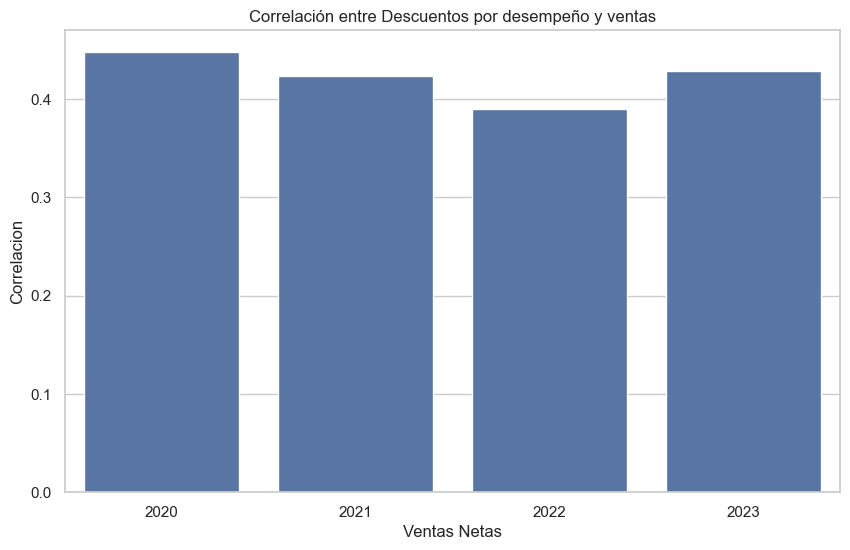

In [53]:
# Seleccionar las columnas de interés
columns_of_interest = ['Año_Fiscal', 'Ventas_Netas', 'Descuentos_distribuidores_desempeño']
data_subset = datos[columns_of_interest]

# Asegurarse de que no hay valores nulos en las columnas de interés
data_subset = data_subset.dropna()

# Calcular la correlación por año
correlation_by_year = data_subset.groupby('Año_Fiscal').apply(
    lambda x: x.corr().loc['Ventas_Netas', 'Descuentos_distribuidores_desempeño']
)

# Mostrar la correlación por año
print(correlation_by_year)

# Graficar la correlación por año
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_by_year.index, y=correlation_by_year.values)
plt.xlabel('Ventas Netas')
plt.ylabel('Correlacion')
plt.title('Correlación entre Descuentos por desempeño y ventas')
plt.show()


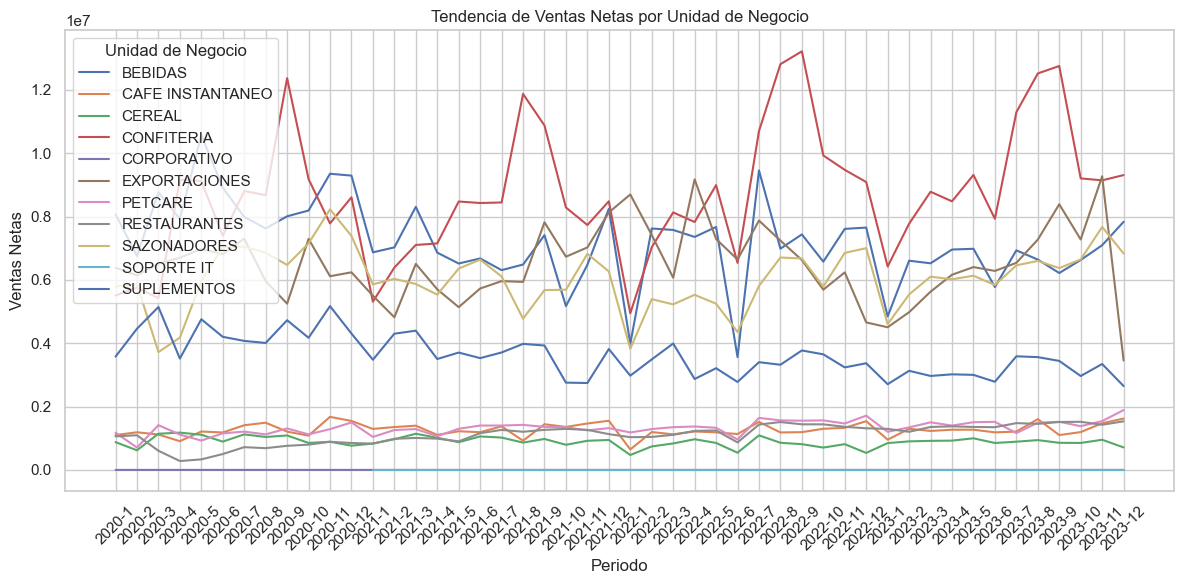

In [54]:
# Agrupar los datos por Unidad de Negocio y Año, y sumar las Ventas Netas
df_grouped = datos.groupby(['Unidad_Negocio', 'Año_Fiscal', 'Periodo_Publicacion'])['Ventas_Netas'].sum().reset_index()

# Crear el gráfico de tendencia
plt.figure(figsize=(12, 6))
for unidad in df_grouped['Unidad_Negocio'].unique():
    unidad_data = df_grouped[df_grouped['Unidad_Negocio'] == unidad]
    plt.plot(unidad_data['Año_Fiscal'].astype(str) + '-' + unidad_data['Periodo_Publicacion'].astype(str), unidad_data['Ventas_Netas'], label=unidad)

plt.title('Tendencia de Ventas Netas por Unidad de Negocio')
plt.xlabel('Periodo')
plt.ylabel('Ventas Netas')
plt.legend(title='Unidad de Negocio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

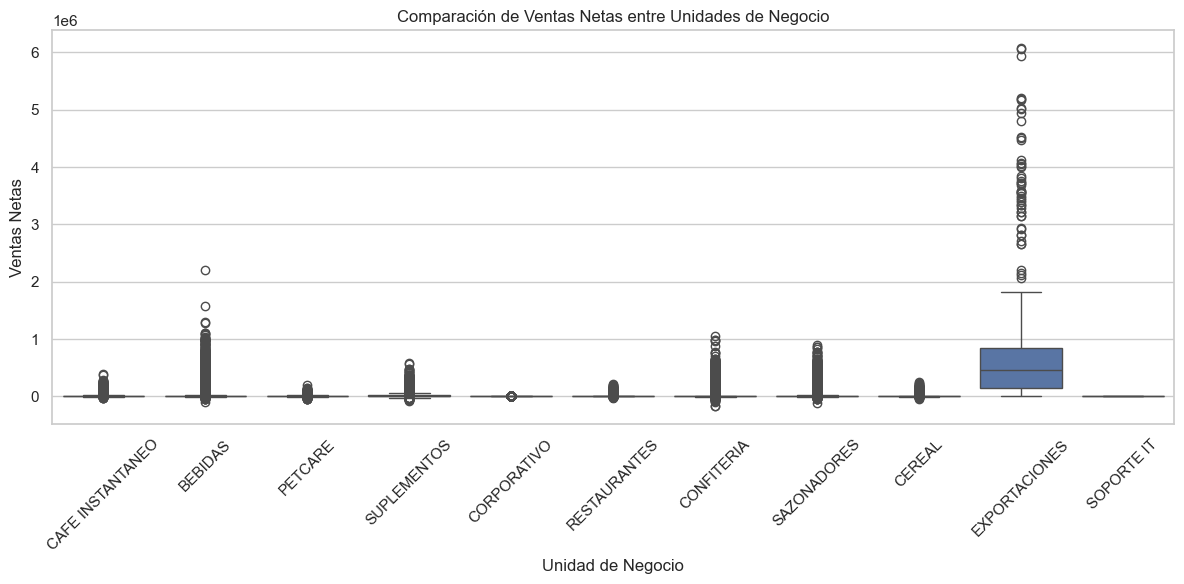

In [55]:
# Comparación de Ventas Netas entre Unidades de Negocio
plt.figure(figsize=(12, 6))
sns.boxplot(x='Unidad_Negocio', y='Ventas_Netas', data=datos)
plt.title('Comparación de Ventas Netas entre Unidades de Negocio')
plt.xlabel('Unidad de Negocio')
plt.ylabel('Ventas Netas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

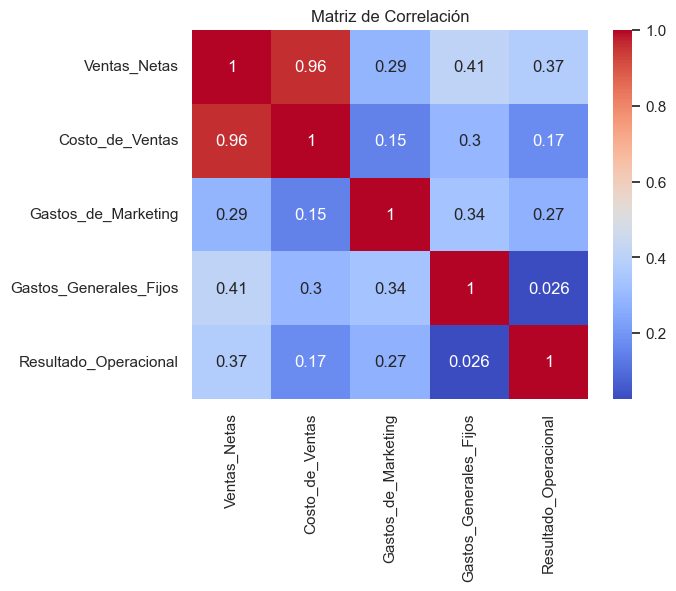

In [56]:
# Matriz de Correlación
correlacion = datos[['Ventas_Netas', 'Costo_de_Ventas', 'Gastos_de_Marketing', 'Gastos_Generales_Fijos', 'Resultado_Operacional']].corr()
sns.heatmap(correlacion, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

In [57]:
print('Cantidad de Filas y columnas:',datos_agrupados.shape)
print('Nombre columnas:',datos_agrupados.columns)

Cantidad de Filas y columnas: (516, 26)
Nombre columnas: Index(['Unidad_Negocio', 'Año_Fiscal', 'Periodo_Publicacion', 'Codigo_Empresa',
       'Company_Name', 'Ventas_Brutas', 'Comunicacion_Total',
       'Medios_Pagados_Tradicionales', 'Costo_Agencia_Produccion',
       'Medios_Pagados_Digitales_Puros', 'Cartera_Dudosa',
       'Reducciones_Generales_Precio', 'Costo_Material_Prima_Menos_Margen',
       'Costo_Propio_Manuf_Menos_Margen', 'Asignaciones_Comerciales',
       'Ventas_Brutas_NNS_3030', 'Ventas_Netas', 'Costo_de_Ventas',
       'Gastos Fijos_de_Fabrica', 'Gastos_de_Marketing',
       'Gastos_Generales_Fijos', 'Descuentos_distribuidores_desempeño',
       'Resultado_Operacional', 'Consolidated_Operating_Profit_COP2',
       'Semestre', 'Trimestre'],
      dtype='object')


In [58]:
#Verificación de tipo de datos por columna
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115187 entries, 0 to 115186
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unidad_Negocio                       115187 non-null  object 
 1   Año_Fiscal                           115187 non-null  int64  
 2   Periodo_Publicacion                  115187 non-null  int64  
 3   Codigo_Empresa                       115187 non-null  object 
 4   Company_Name                         115187 non-null  object 
 5   Ventas_Brutas                        115187 non-null  float64
 6   Comunicacion_Total                   115187 non-null  float64
 7   Medios_Pagados_Tradicionales         115187 non-null  float64
 8   Costo_Agencia_Produccion             115187 non-null  float64
 9   Medios_Pagados_Digitales_Puros       115187 non-null  float64
 10  Cartera_Dudosa                       115187 non-null  float64
 11  Reducciones_G

In [59]:
#Mostrando análisis descriptivo
print("Análisis Descriptivo:")
print(datos_agrupados.describe())

Análisis Descriptivo:
        Año_Fiscal  Periodo_Publicacion  Ventas_Brutas  Comunicacion_Total  \
count   516.000000           516.000000   5.160000e+02          516.000000   
mean   2021.534884             6.500000   4.086284e+06        72436.331008   
std       1.108110             3.455402   3.785883e+06       101345.193414   
min    2020.000000             1.000000   0.000000e+00      -230758.270000   
25%    2021.000000             3.750000   1.158039e+06            0.000000   
50%    2022.000000             6.500000   1.921406e+06        35983.035000   
75%    2023.000000             9.250000   7.199605e+06       105645.697500   
max    2023.000000            12.000000   1.676470e+07       697705.470000   

       Medios_Pagados_Tradicionales  Costo_Agencia_Produccion  \
count                    516.000000                516.000000   
mean                   11446.294070               9549.497500   
std                    40990.166474              25437.495093   
min            

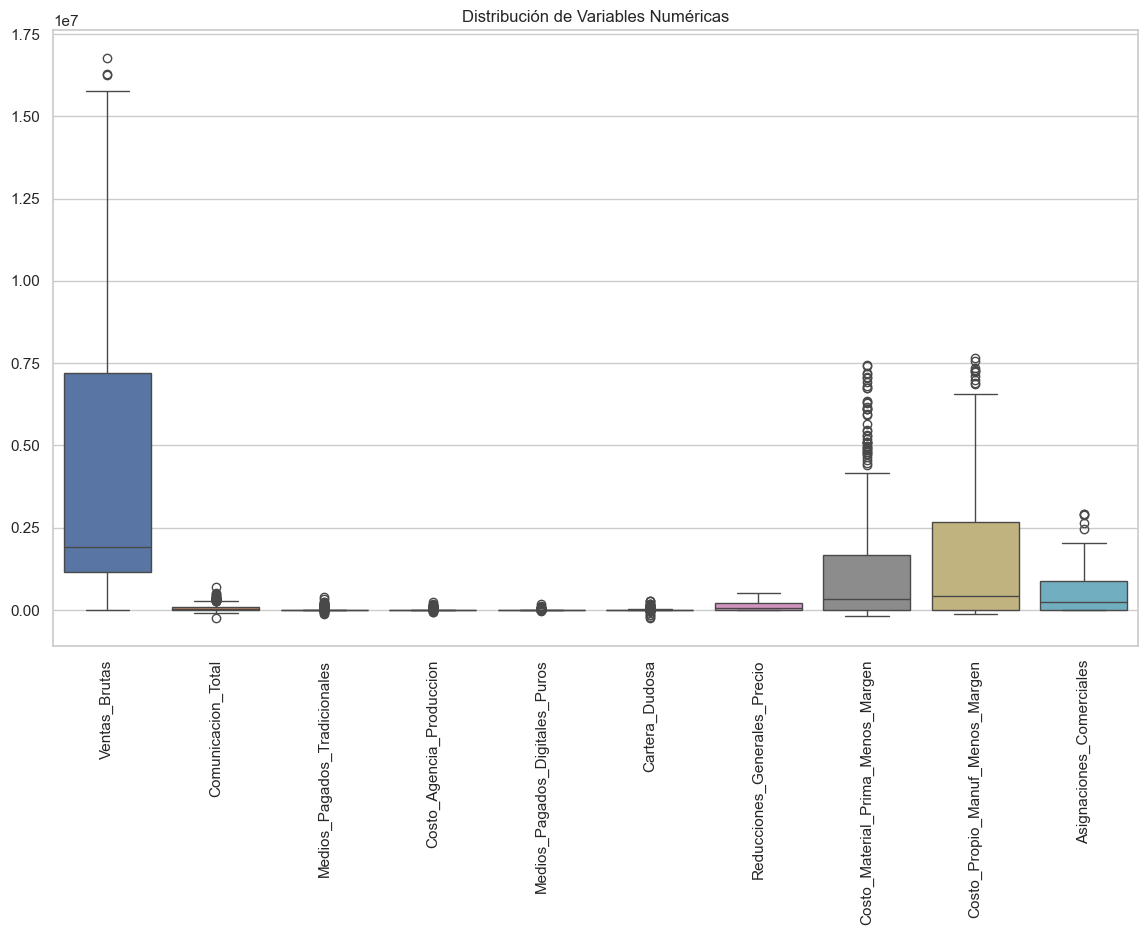

In [60]:
# Se separa las variables numericas para generar la matriz de correlación de variables predictoras
datos_corr = datos_agrupados[[
    "Ventas_Brutas",
    "Comunicacion_Total",
    "Medios_Pagados_Tradicionales",
    "Costo_Agencia_Produccion",
    "Medios_Pagados_Digitales_Puros",
    "Cartera_Dudosa",
    "Reducciones_Generales_Precio",  
    "Costo_Material_Prima_Menos_Margen", 
    "Costo_Propio_Manuf_Menos_Margen",  
    "Asignaciones_Comerciales"
    ]]

# Gráficos Descriptivos
plt.figure(figsize=(14, 8))
sns.boxplot(data=datos_corr.select_dtypes(include=[np.number]))
plt.title('Distribución de Variables Numéricas')
plt.xticks(rotation=90)
plt.show()

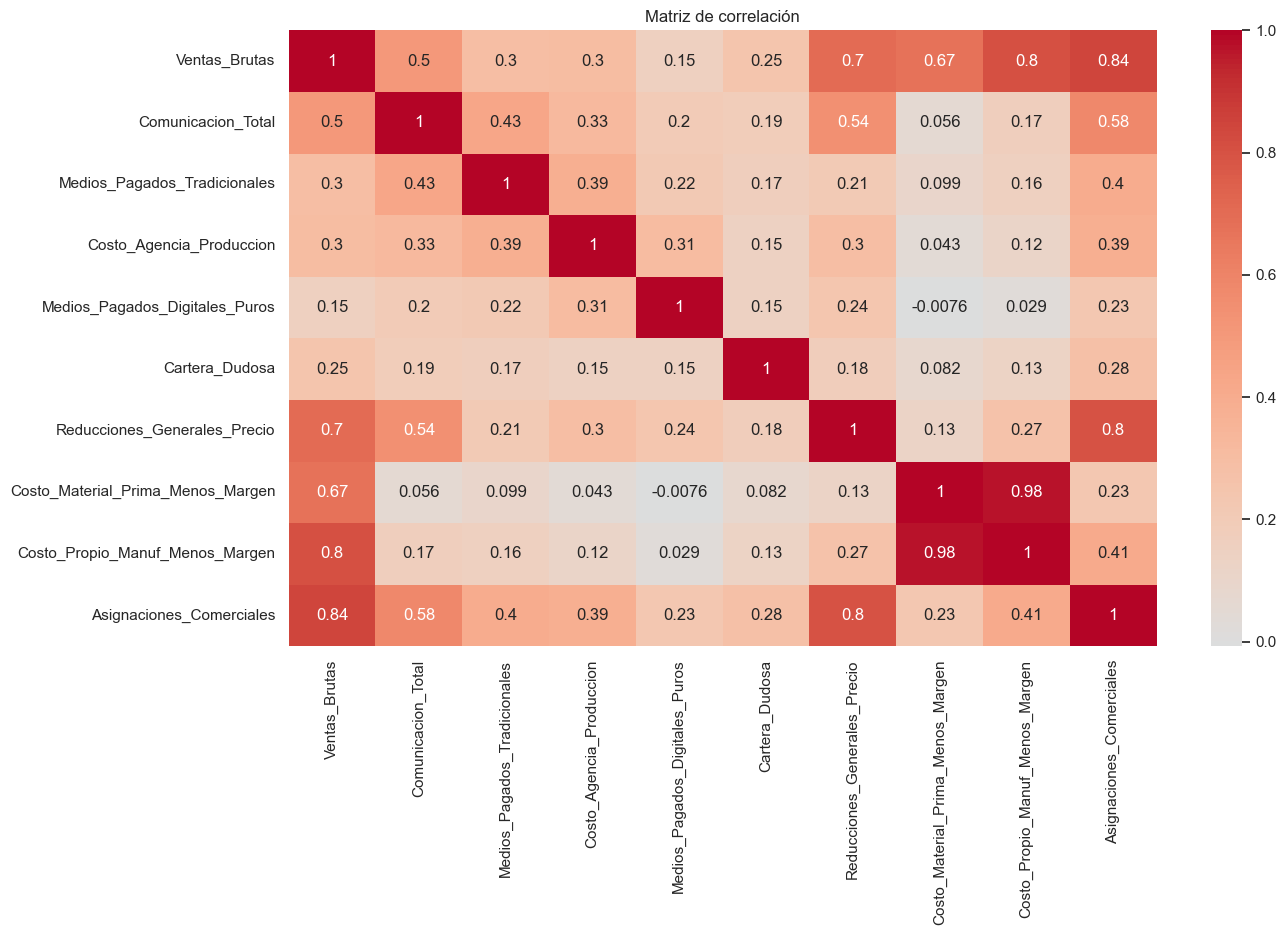

In [61]:
# Matriz de correlacion de variablesp pedictoras para conocer su relación
plt.figure(figsize=(14, 8))
sns.heatmap(datos_corr.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de correlación')
plt.show()

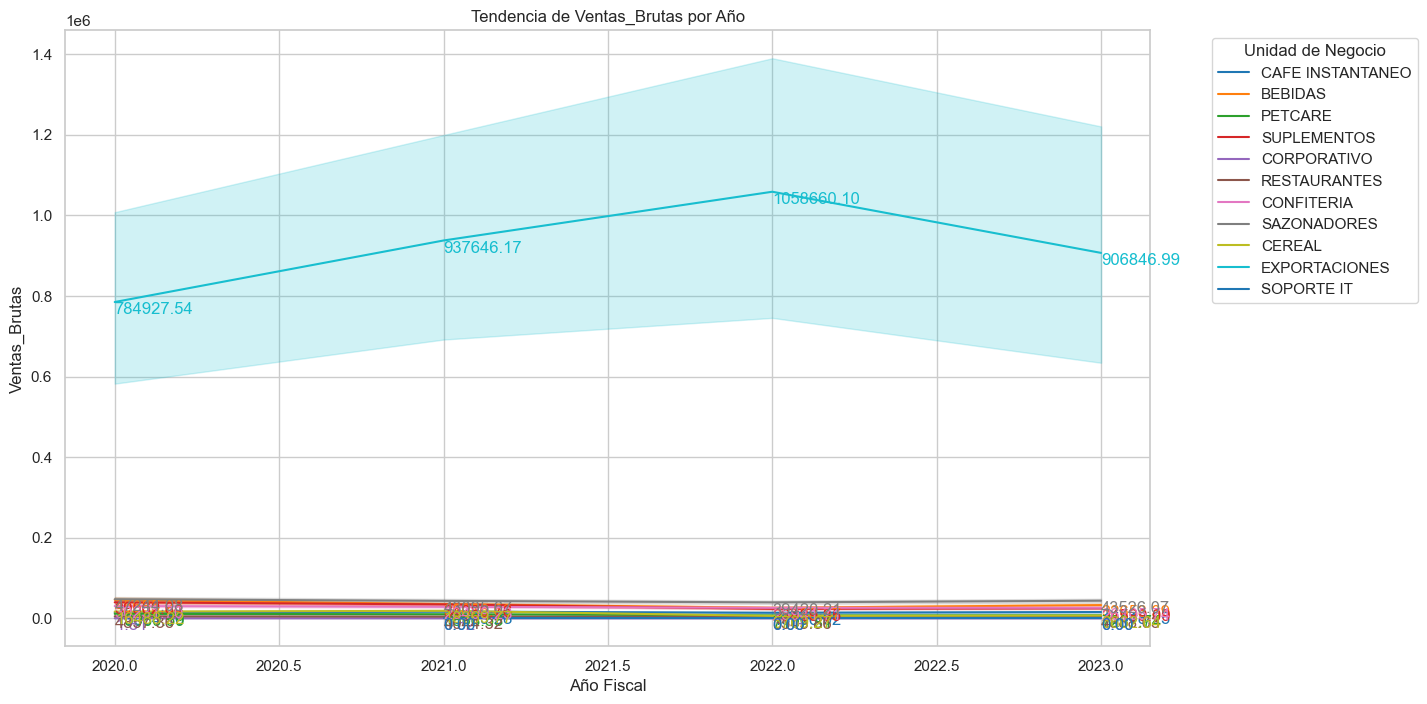

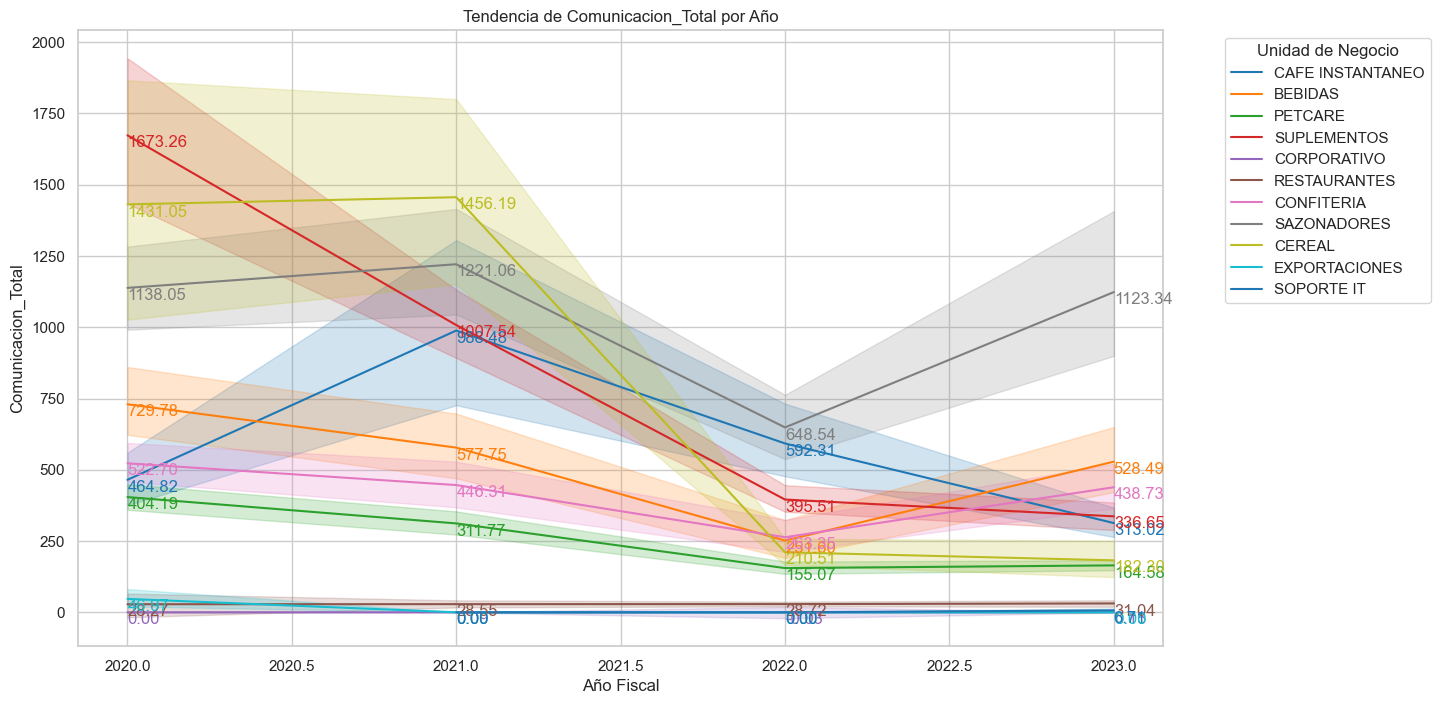

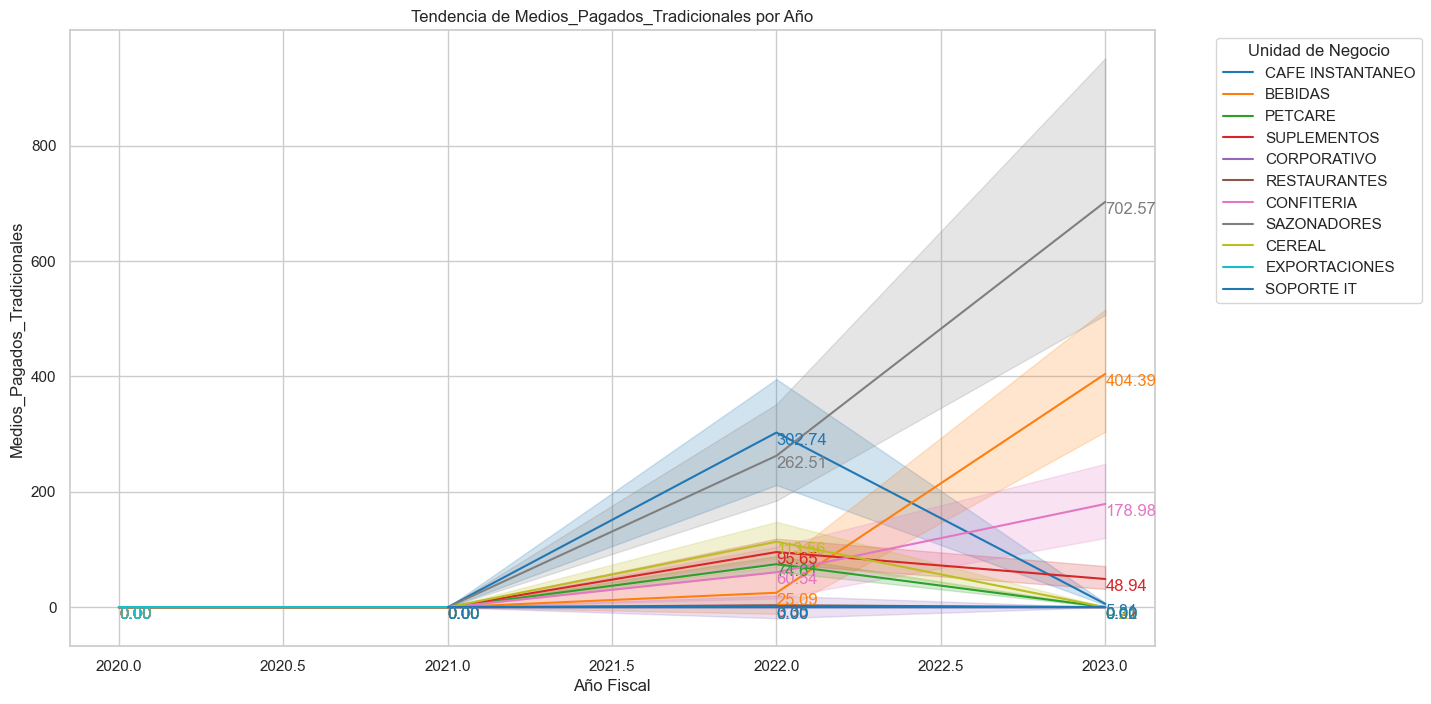

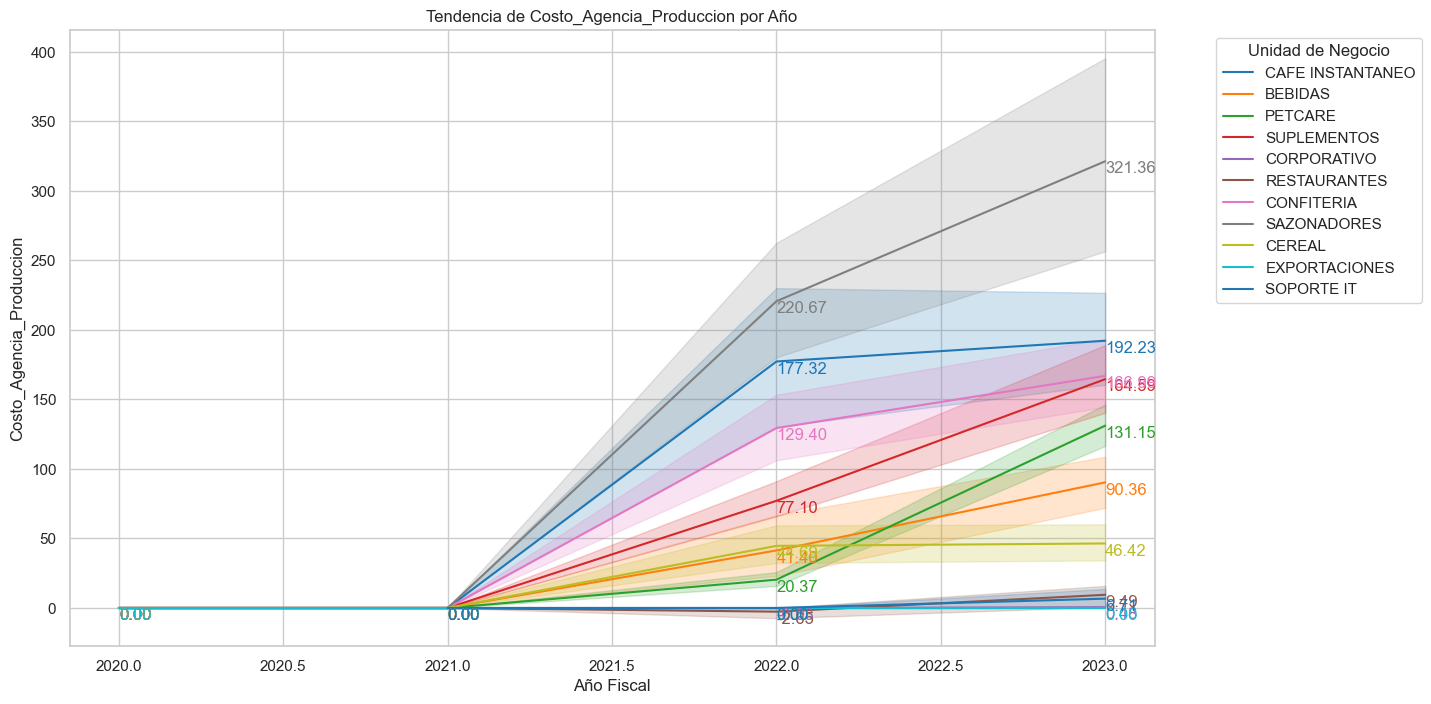

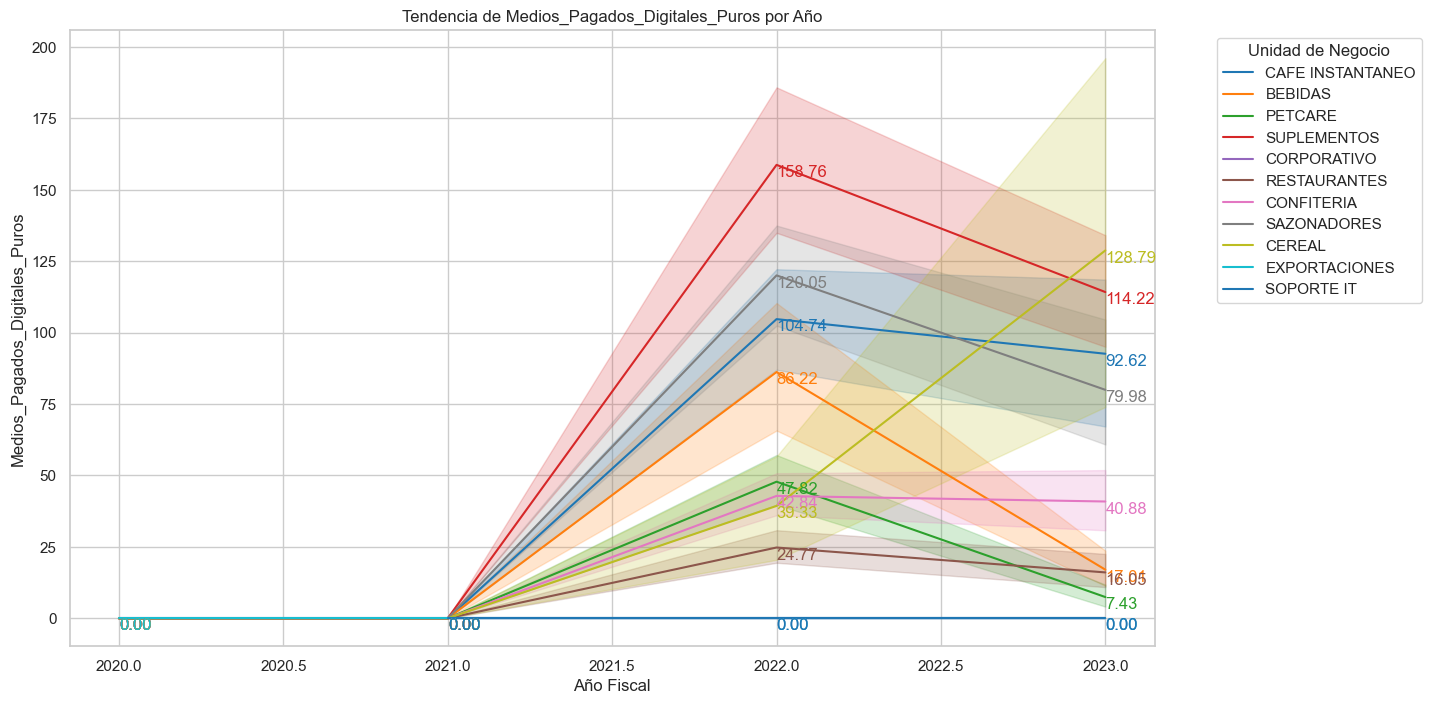

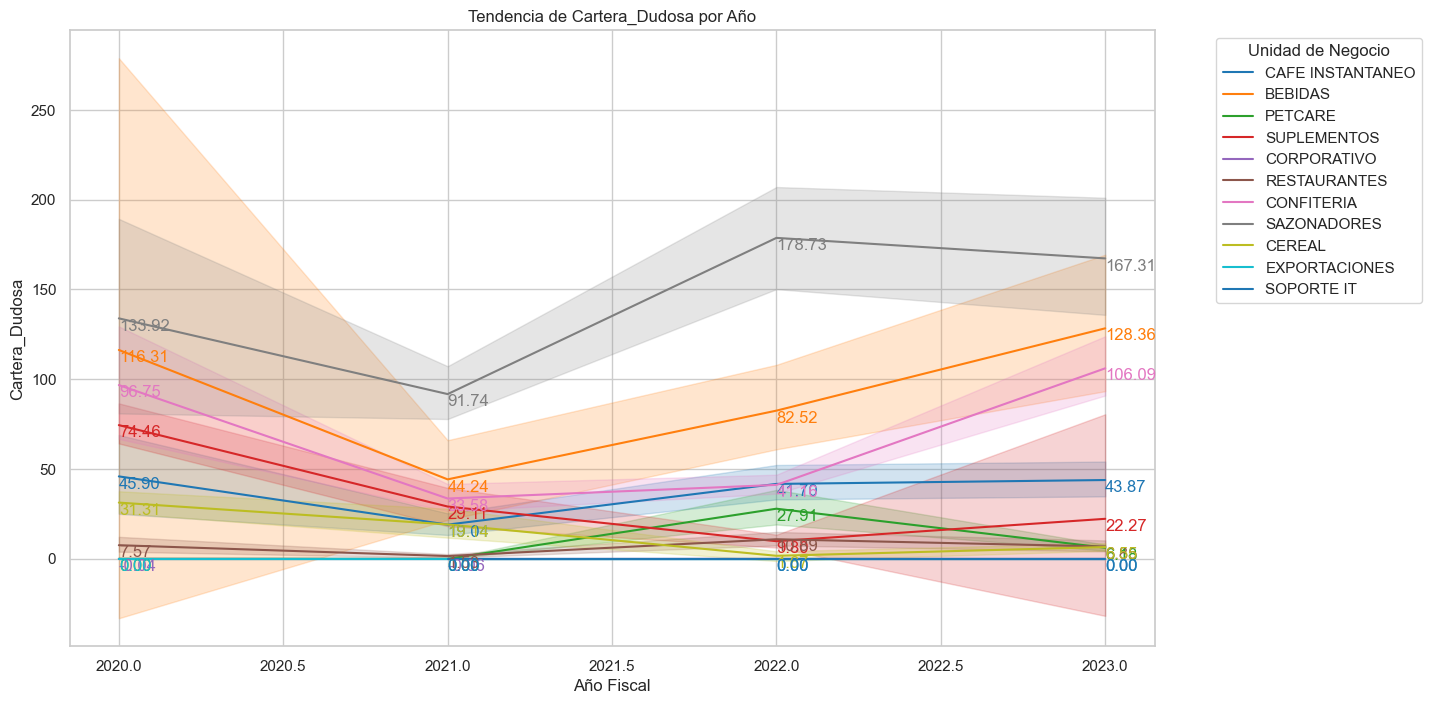

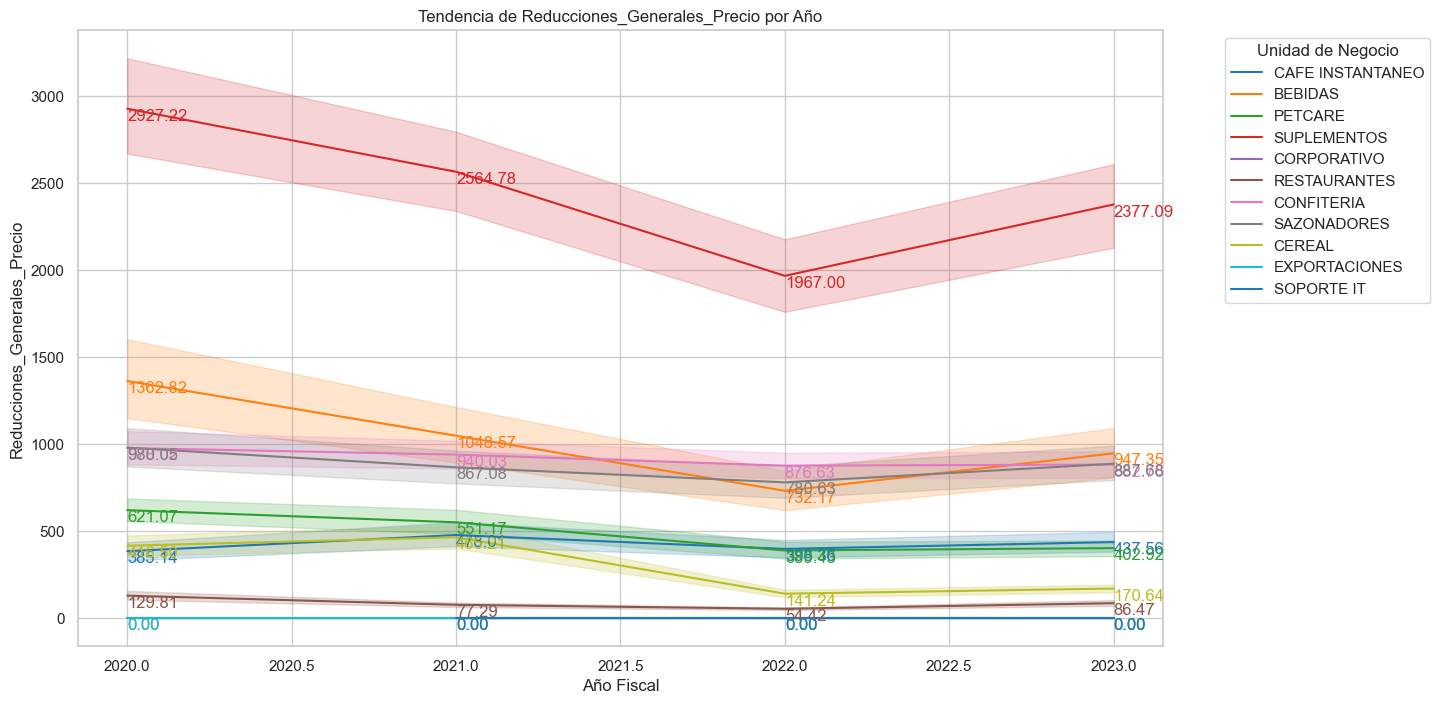

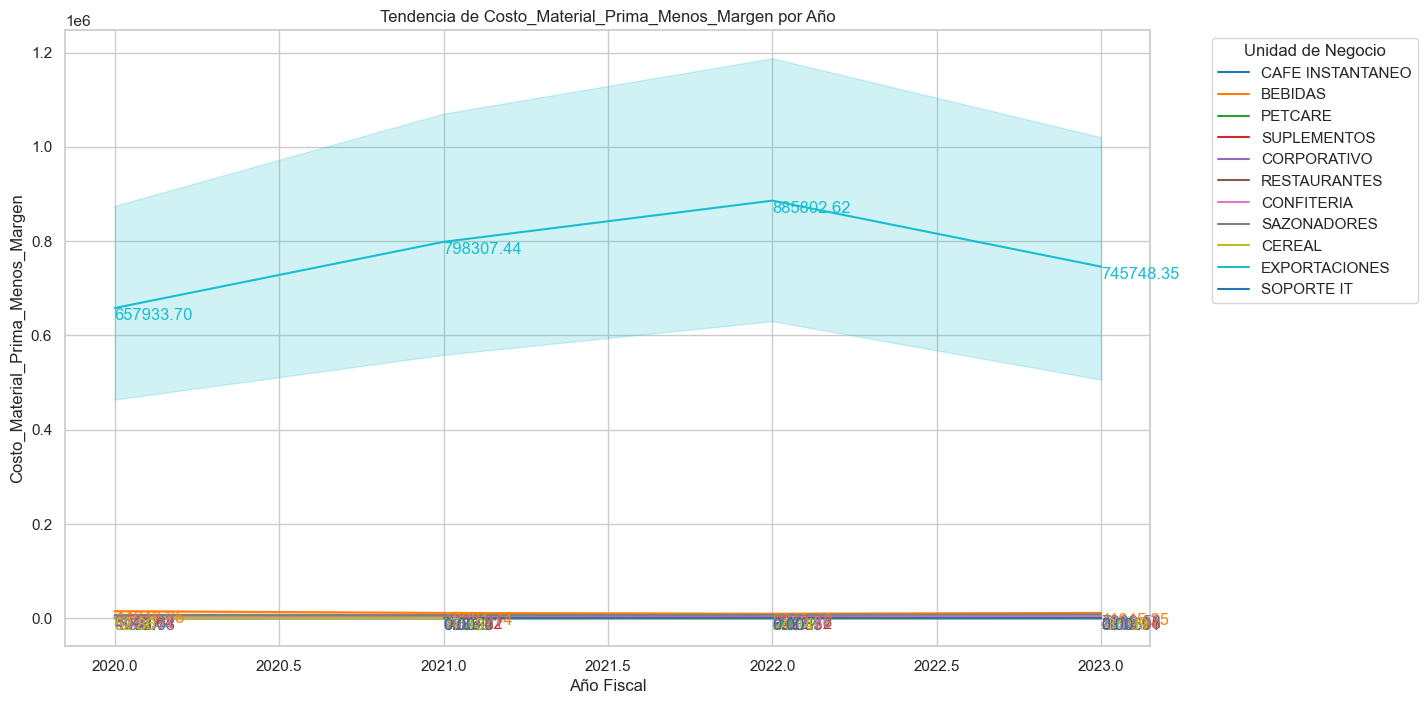

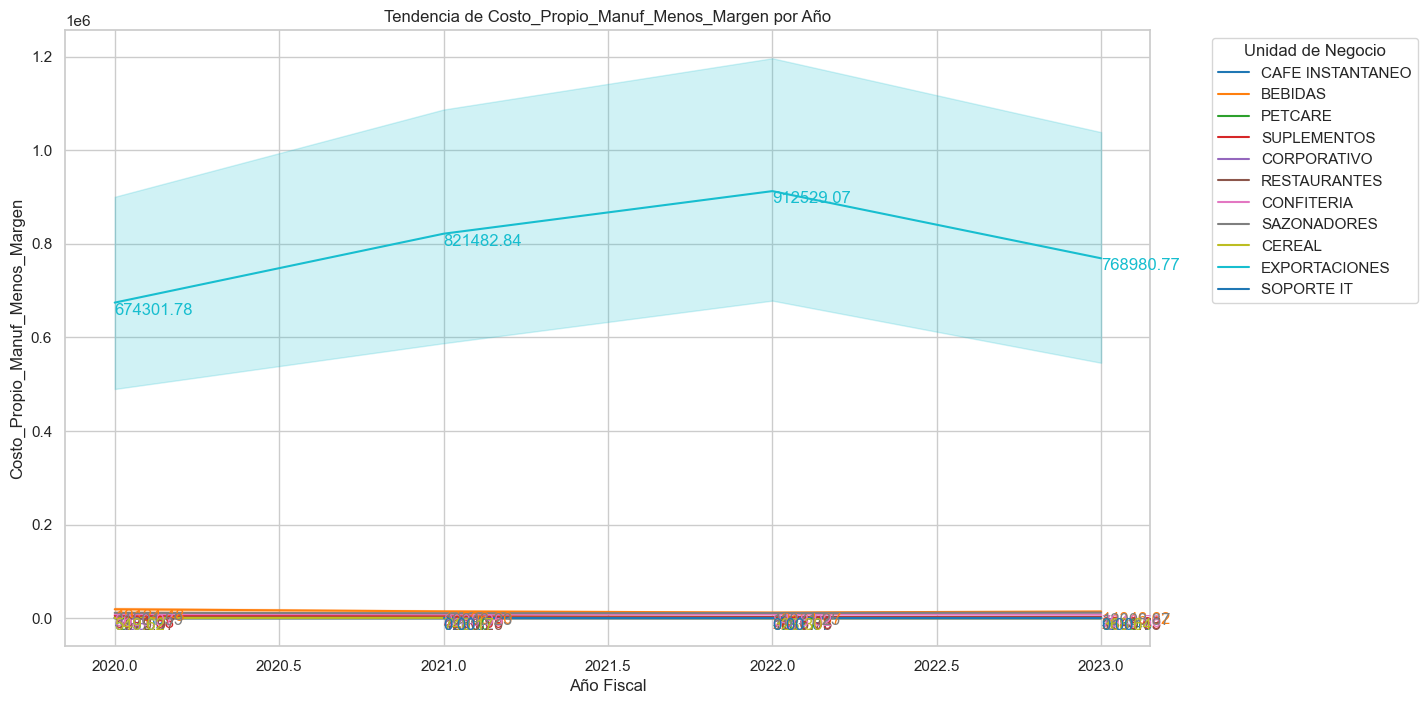

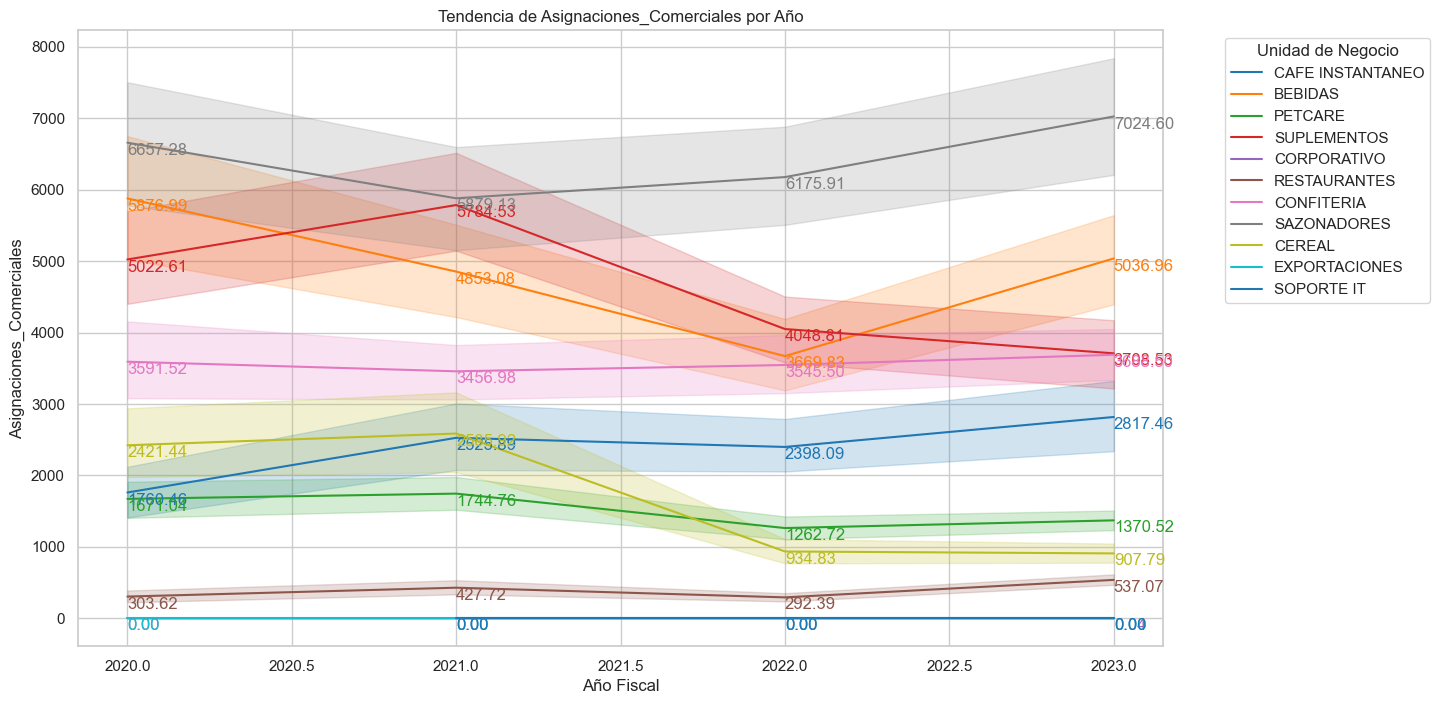

In [62]:
# Lista de variables para graficar
variables = [
    'Ventas_Brutas',
    'Comunicacion_Total',
    'Medios_Pagados_Tradicionales',
    'Costo_Agencia_Produccion',
    'Medios_Pagados_Digitales_Puros',
    'Cartera_Dudosa',
    'Reducciones_Generales_Precio',  
    'Costo_Material_Prima_Menos_Margen', 
    'Costo_Propio_Manuf_Menos_Margen',  
    'Asignaciones_Comerciales'
]

# Graficar tendencias por variable por año
for variable in variables:
    plt.figure(figsize=(14, 8))
    ax = sns.lineplot(data=datos, x='Año_Fiscal', y=variable, hue='Unidad_Negocio', palette='tab10')
    plt.title(f'Tendencia de {variable} por Año')
    plt.xlabel('Año Fiscal')
    plt.ylabel(variable)
    plt.grid(True)
    plt.legend(title='Unidad de Negocio', bbox_to_anchor=(1.05, 1), loc='upper left')
    for line in ax.lines:
        for x, y in zip(line.get_xdata(), line.get_ydata()):
            if not pd.isnull(y):
                ax.text(x, y, f'{y:.2f}', color=line.get_color(), ha="left", va="top")

    plt.show()

## CRISP-DM Etapa 3: Data Preparation (Preparación de los Datos)

In [63]:
# Preparar los datos para el análisis, incluyendo selección de variables y transformación de datos.
# Variables predictoras y objetivo
predictoras = [
    "Ventas_Brutas",
    "Comunicacion_Total",
    "Medios_Pagados_Tradicionales",
    "Costo_Agencia_Produccion",
    "Medios_Pagados_Digitales_Puros",
    "Cartera_Dudosa",
    "Reducciones_Generales_Precio",  
    "Costo_Material_Prima_Menos_Margen", 
    "Costo_Propio_Manuf_Menos_Margen",  
    "Asignaciones_Comerciales"
]

objetivos_ridge = [
    'Medios_Pagados_Digitales_Puros',
    'Cartera_Dudosa'
]

objetivos_arima = [
    'Ventas_Brutas',
    'Costo_Material_Prima_Menos_Margen'
]

# Extraer las variables predictoras y las variables objetivo
X = datos_agrupados[predictoras]
y_ridge = datos_agrupados[objetivos_ridge]
y_arima = datos_agrupados[objetivos_arima]

# Transformar características polinómicas
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

## CRISP-DM Etapa 4: Modeling (Modelado)

### Modelado Regresión RIDGE

In [64]:
# Seleccionar y aplicar técnicas de modelado, y calibrar los parámetros del modelo.

# MODELO RIDGE

# Parámetros para GridSearchCV
parametros_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Parametrizar la cantidad de fits
n_jobs = -1  # Número de trabajos paralelos (usar -1 para usar todos los núcleos disponibles)
verbose = 1  # Nivel de verbosidad

def entrenar_modelo(modelo, parametros, X_train, y_train, objetivo, n_jobs, verbose):
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    busqueda_grid = GridSearchCV(estimator=modelo, param_grid=parametros, cv=kfold, scoring='neg_mean_squared_error', n_jobs=n_jobs, verbose=verbose)
    busqueda_grid.fit(X_train, y_train)
    
    # Guardar los mejores hiperparámetros
    joblib.dump(busqueda_grid.best_params_, f'best_params_{objetivo}.pkl')
    joblib.dump(busqueda_grid.best_estimator_, f'best_model_{objetivo}.pkl')
    
    return busqueda_grid.best_estimator_, busqueda_grid.best_params_

def cargar_mejores_hiperparametros(objetivo):
    if os.path.exists(f'best_params_{objetivo}.pkl'):
        return joblib.load(f'best_params_{objetivo}.pkl')
    return None

# Entrenar y evaluar modelos de Ridge para los objetivos específicos
resultados_ridge = {}
mejores_modelos_ridge = {}
mejores_parametros_ridge = {}

# Escalar las variables objetivo
escaladores_objetivo = {objetivo: StandardScaler() for objetivo in objetivos_ridge}
y_ridge_scaled = pd.DataFrame(index=y_ridge.index)

for objetivo in objetivos_ridge:
    y_ridge_scaled[objetivo] = escaladores_objetivo[objetivo].fit_transform(y_ridge[[objetivo]]).flatten()

for objetivo in objetivos_ridge:
    modelo = Ridge()
    parametros = parametros_ridge
    
    # Selección de características
    selector = SelectKBest(score_func=f_regression, k='all')
    X_poly_seleccionado = selector.fit_transform(X_poly, y_ridge_scaled[objetivo])
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_poly_seleccionado, y_ridge_scaled[objetivo], test_size=0.3, random_state=42)
    
    # Normalizar los datos
    escalador = StandardScaler()
    X_train_escalado = escalador.fit_transform(X_train)
    X_test_escalado = escalador.transform(X_test)
    
    # Cargar los mejores hiperparámetros si existen, si no, entrenar el modelo
    mejores_parametros = cargar_mejores_hiperparametros(objetivo)
    if mejores_parametros:
        mejor_modelo = Ridge(**mejores_parametros)
        mejor_modelo.fit(X_train_escalado, y_train)
    else:
        mejor_modelo, mejores_parametros = entrenar_modelo(modelo, parametros, X_train_escalado, y_train, objetivo, n_jobs, verbose)
    
    mejores_modelos_ridge[objetivo] = mejor_modelo
    mejores_parametros_ridge[objetivo] = mejores_parametros
    
    # Evaluar el modelo
    predicciones_escaladas = mejor_modelo.predict(X_test_escalado)
    predicciones = escaladores_objetivo[objetivo].inverse_transform(predicciones_escaladas.reshape(-1, 1)).flatten()
    y_test_original = escaladores_objetivo[objetivo].inverse_transform(y_test.values.reshape(-1, 1)).flatten()
    
    mse = mean_squared_error(y_test_original, predicciones)
    mae = mean_absolute_error(y_test_original, predicciones)
    r2 = r2_score(y_test_original, predicciones)
    
    resultados_ridge[objetivo] = {
        'ECM': mse,       
        'R2': r2
    }
    print(f'Rendimiento de Ridge para {objetivo}:')
    print(f'Error Cuadrático Medio: {mse}')    
    print(f'Puntuación R^2: {r2}')
    print(f'Mejores Hiperparámetros: {mejores_parametros}\n')

# Fórmula Matemática de Ridge Regression
print("Fórmula Matemática del Modelo Ridge:")
print("y = Xw + b + λ||w||^2")
print("donde:")
print("y = Vector de predicciones")
print("X = Matriz de características")
print("w = Vector de coeficientes")
print("b = Intercepto")
print("λ = Parámetro de regularización")

# Crear un DataFrame para las predicciones del año 2024 utilizando los datos del año 2023
if not datos_agrupados[datos_agrupados['Año_Fiscal'] == 2023].empty:
    datos_2024 = datos_agrupados[datos_agrupados['Año_Fiscal'] == 2023].copy()
else:
    ultimo_año = datos_agrupados['Año_Fiscal'].max()
    datos_2024 = datos_agrupados[datos_agrupados['Año_Fiscal'] == ultimo_año].copy()

datos_2024['Año_Fiscal'] = 2024
datos_2024['Periodo_Publicacion'] = list(range(1, 13)) * (len(datos_2024) // 12)
datos_2024['Semestre'] = np.where(datos_2024['Periodo_Publicacion'] <= 6, 1, 2)
datos_2024['Trimestre'] = np.ceil(datos_2024['Periodo_Publicacion'] / 3).astype(int)

# Transformar y escalar los nuevos datos
X_poly_2024 = poly.transform(datos_2024[predictoras])
predicciones_2024_ridge = {}

# Predicciones con Ridge Regression para los objetivos seleccionados
for objetivo in objetivos_ridge:
    mejor_modelo = mejores_modelos_ridge[objetivo]
    
    # Seleccionar características y escalar
    selector = SelectKBest(score_func=f_regression, k='all')
    X_poly_seleccionado = selector.fit_transform(X_poly, y_ridge_scaled[objetivo])
    X_poly_seleccionado_2024 = selector.transform(X_poly_2024)
    escalador = StandardScaler()
    X_escalado_2024 = escalador.fit_transform(X_poly_seleccionado_2024)
    
    # Predecir con el mejor modelo
    predicciones_2024_escaladas = mejor_modelo.predict(X_escalado_2024)
    predicciones_2024 = escaladores_objetivo[objetivo].inverse_transform(predicciones_2024_escaladas.reshape(-1, 1)).flatten()
    
    datos_2024[objetivo] = predicciones_2024

# Seleccionar solo las columnas necesarias para la salida
columnas_salida_ridge = [
    'Unidad_Negocio', 'Año_Fiscal', 'Periodo_Publicacion', 'Semestre', 'Trimestre', 'Codigo_Empresa',
    'Medios_Pagados_Digitales_Puros', 'Cartera_Dudosa'
]

predicciones_ridge_2024 = datos_2024[columnas_salida_ridge]

Fitting 10 folds for each of 42 candidates, totalling 420 fits


Rendimiento de Ridge para Medios_Pagados_Digitales_Puros:
Error Cuadrático Medio: 11.950987590205811
Puntuación R^2: 0.9999999698763895
Mejores Hiperparámetros: {'alpha': 0.01, 'solver': 'svd'}

Fitting 10 folds for each of 42 candidates, totalling 420 fits


/Users/cayerve/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cayerve/Library/Python/

Rendimiento de Ridge para Cartera_Dudosa:
Error Cuadrático Medio: 349.50018586759904
Puntuación R^2: 0.9999996436189778
Mejores Hiperparámetros: {'alpha': 0.01, 'solver': 'svd'}

Fórmula Matemática del Modelo Ridge:
y = Xw + b + λ||w||^2
donde:
y = Vector de predicciones
X = Matriz de características
w = Vector de coeficientes
b = Intercepto
λ = Parámetro de regularización


/Users/cayerve/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Resultados del Modelos Ridge

#### Rendimiento de Ridge para Medios_Pagados_Digitales_Puros:
- **Error Cuadrático Medio (MSE):** 11.950987590215219
- **Puntuación R²:** 0.9999999698763895
- **Mejores Hiperparámetros:** {'alpha': 0.01, 'solver': 'svd'}

Interpretación:
El modelo Ridge para la variable objetivo "Medios_Pagados_Digitales_Puros" ha obtenido un Error Cuadrático Medio (MSE) de 11.950987590215219, lo que indica que las predicciones del modelo están muy cerca de los valores reales. La puntuación R² de 0.9999999698763895 sugiere que el modelo explica casi el 100% de la variabilidad en los datos. Los mejores hiperparámetros encontrados fueron 'alpha': 0.01 y 'solver': 'svd'.

#### Rendimiento de Ridge para Cartera_Dudosa:
- **Error Cuadrático Medio (MSE):** 349.50018586759904
- **Puntuación R²:** 0.9999996436189778
- **Mejores Hiperparámetros:** {'alpha': 0.01, 'solver': 'svd'}

Interpretación:
El modelo Ridge para la variable objetivo "Cartera_Dudosa" ha obtenido un Error Cuadrático Medio (MSE) de 349.50018586759904, indicando que las predicciones del modelo están muy cerca de los valores reales. La puntuación R² de 0.9999996436189778 sugiere que el modelo explica casi el 100% de la variabilidad en los datos. Los mejores hiperparámetros encontrados fueron 'alpha': 0.01 y 'solver': 'svd'.



Ridge Regression:
La regresión Ridge añade un término de penalización a la regresión lineal para evitar el sobreajuste:


La regresión Ridge añade un término de penalización a la regresión lineal para evitar el sobreajuste. La función de costo para Ridge Regression es:

$$
\text{Minimizar} \quad \frac{1}{n} \sum_{i=1}^{n} (y_i - \mathbf{x}_i^\top \mathbf{w})^2 + \lambda \|\mathbf{w}\|^2
$$

donde:
- \( y_i \) es el valor objetivo.
- \( x_i \) es el vector de características.
- \( w \) es el vector de coeficientes.
- \( λ\) es el parámetro de regularización.

### Modelado ARIMA SERIES TEMPORALES

In [65]:
# MODELO ARIMA
from itertools import product
import warnings
# Filtrar los datos originales para la predicción de ARIMA y evaluar métricas
datos_agrupados_arima = datos.groupby(['Unidad_Negocio', 'Año_Fiscal', 'Periodo_Publicacion', 'Codigo_Empresa'])[['Ventas_Brutas', 'Costo_Material_Prima_Menos_Margen']].sum().reset_index()

predicciones_arima = []
metricas_arima = []

combinaciones_unicas = datos_agrupados_arima[['Unidad_Negocio', 'Codigo_Empresa']].drop_duplicates()

# Ampliar el rango de hiperparámetros
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

param_grid = list(product(p_values, d_values, q_values))

# Función para encontrar el mejor modelo ARIMA
def buscar_mejores_parametros(serie, param_grid):
    mejor_score = float("inf")
    mejores_parametros = None
    mejor_modelo = None
    for parametros in param_grid:
        try:
            modelo = ARIMA(serie, order=parametros)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                ajuste = modelo.fit()
            predicciones = ajuste.forecast(steps=12)
            score = mean_squared_error(serie[-12:], predicciones)
            if score < mejor_score:
                mejor_score = score
                mejores_parametros = parametros
                mejor_modelo = ajuste
        except (np.linalg.LinAlgError, ValueError):
            continue
    return mejores_parametros, mejor_modelo

for index, fila in combinaciones_unicas.iterrows():
    unidad_negocio = fila['Unidad_Negocio']
    codigo_empresa = fila['Codigo_Empresa']
    
    datos_grupo = datos_agrupados_arima[(datos_agrupados_arima['Unidad_Negocio'] == unidad_negocio) & (datos_agrupados_arima['Codigo_Empresa'] == codigo_empresa)]
    
    serie_ventas = datos_grupo.set_index(['Año_Fiscal', 'Periodo_Publicacion'])['Ventas_Brutas']
    serie_costo = datos_grupo.set_index(['Año_Fiscal', 'Periodo_Publicacion'])['Costo_Material_Prima_Menos_Margen']
    
    # Intentar ajustar el modelo ARIMA con búsqueda de hiperparámetros para Ventas Brutas
    try:
        parametros_ventas, modelo_ventas = buscar_mejores_parametros(serie_ventas, param_grid)
        if modelo_ventas is None:
            print(f"No se pudo ajustar modelo para {unidad_negocio}, {codigo_empresa} para Ingresos Brutos de Ventas")
            continue
        pronostico_ventas = modelo_ventas.forecast(steps=12)
        # Guardar el modelo y los hiperparámetros
        joblib.dump(parametros_ventas, f'mejores_parametros_ventas_{unidad_negocio}_{codigo_empresa}.pkl')
        joblib.dump(modelo_ventas, f'mejor_modelo_ventas_{unidad_negocio}_{codigo_empresa}.pkl')
    except (np.linalg.LinAlgError, ValueError) as e:
        print(f"Error en {unidad_negocio}, {codigo_empresa} para Ingresos Brutos de Ventas: {e}")
        continue
    
    # Intentar ajustar el modelo ARIMA con búsqueda de hiperparámetros para Costo de Material Prima Menos Margen
    try:
        parametros_costo, modelo_costo = buscar_mejores_parametros(serie_costo, param_grid)
        if modelo_costo is None:
            print(f"No se pudo ajustar modelo para {unidad_negocio}, {codigo_empresa} para Costo de Material Prima Menos Margen")
            continue
        pronostico_costo = modelo_costo.forecast(steps=12)
        # Guardar el modelo y los hiperparámetros
        joblib.dump(parametros_costo, f'mejores_parametros_costo_{unidad_negocio}_{codigo_empresa}.pkl')
        joblib.dump(modelo_costo, f'mejor_modelo_costo_{unidad_negocio}_{codigo_empresa}.pkl')
    except (np.linalg.LinAlgError, ValueError) as e:
        print(f"Error en {unidad_negocio}, {codigo_empresa} para Costo de Material Prima Menos Margen: {e}")
        continue
    
    ecm_ventas = mean_squared_error(serie_ventas[-12:], pronostico_ventas)
    mae_ventas = mean_absolute_error(serie_ventas[-12:], pronostico_ventas)
    ecm_costo = mean_squared_error(serie_costo[-12:], pronostico_costo)
    mae_costo = mean_absolute_error(serie_costo[-12:], pronostico_costo)
    
    metricas_arima.append({
        'Unidad_Negocio': unidad_negocio,
        'Codigo_Empresa': codigo_empresa,
        'ECM_Ventas': ecm_ventas,
        'MAE_Ventas': mae_ventas,
        'R2_Ventas': 1 - ecm_ventas / np.var(serie_ventas[-12:]),
        'Mejores_Hiperparámetros_Ventas': parametros_ventas,
        'ECM_Costo': ecm_costo,
        'MAE_Costo': mae_costo,
        'R2_Costo': 1 - ecm_costo / np.var(serie_costo[-12:]),
        'Mejores_Hiperparámetros_Costo': parametros_costo
    })
    
    for i, (pred_ventas, pred_costo) in enumerate(zip(pronostico_ventas, pronostico_costo), start=1):
        predicciones_arima.append({
            'Unidad_Negocio': unidad_negocio,
            'Año_Fiscal': 2024,
            'Periodo_Publicacion': i,
            'Semestre': 1 if i <= 6 else 2,
            'Trimestre': (i - 1) // 3 + 1,
            'Codigo_Empresa': codigo_empresa,
            'Ventas_Brutas': pred_ventas,
            'Costo_Material_Prima_Menos_Margen': pred_costo
        })

# Convertir las predicciones y métricas a DataFrames
predicciones_arima_df = pd.DataFrame(predicciones_arima)
metricas_arima_df = pd.DataFrame(metricas_arima)

# Seleccionar solo las columnas necesarias para la salida de ARIMA
columnas_salida_arima = [
    'Unidad_Negocio', 'Año_Fiscal', 'Periodo_Publicacion', 'Semestre', 'Trimestre', 'Codigo_Empresa',
    'Ventas_Brutas', 'Costo_Material_Prima_Menos_Margen'
]

predicciones_arima_2024 = predicciones_arima_df[columnas_salida_arima]

# Mostrar las métricas y mejores hiperparámetros
for index, fila in metricas_arima_df.iterrows():
    print(f"Unidad de Negocio: {fila['Unidad_Negocio']}, Código Empresa: {fila['Codigo_Empresa']}")
    print(f"Mejores Hiperparámetros para Ventas Brutas: {fila['Mejores_Hiperparámetros_Ventas']}")
    print(f"Error Cuadrático Medio (ECM) para Ventas Brutas: {fila['ECM_Ventas']}")
    print(f"Error Absoluto Medio (MAE) para Ventas Brutas: {fila['MAE_Ventas']}")
    print(f"Puntuación R² para Ventas Brutas: {fila['R2_Ventas']}")
    print()
    print(f"Mejores Hiperparámetros para Costo de Material Prima Menos Margen: {fila['Mejores_Hiperparámetros_Costo']}")
    print(f"Error Cuadrático Medio (ECM) para Costo de Material Prima Menos Margen: {fila['ECM_Costo']}")
    print(f"Error Absoluto Medio (MAE) para Costo de Material Prima Menos Margen: {fila['MAE_Costo']}")
    print(f"Puntuación R² para Costo de Material Prima Menos Margen: {fila['R2_Costo']}")
    print()


/Users/cayerve/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_

Unidad de Negocio: BEBIDAS, Código Empresa: EC12
Mejores Hiperparámetros para Ventas Brutas: (5, 0, 5)
Error Cuadrático Medio (ECM) para Ventas Brutas: 881043540678.3599
Error Absoluto Medio (MAE) para Ventas Brutas: 765285.4477096706
Puntuación R² para Ventas Brutas: 0.028350087776265465

Mejores Hiperparámetros para Costo de Material Prima Menos Margen: (5, 0, 5)
Error Cuadrático Medio (ECM) para Costo de Material Prima Menos Margen: 81221229979.50143
Error Absoluto Medio (MAE) para Costo de Material Prima Menos Margen: 205661.2869918097
Puntuación R² para Costo de Material Prima Menos Margen: 0.21520232761764446

Unidad de Negocio: CAFE INSTANTANEO, Código Empresa: EC12
Mejores Hiperparámetros para Ventas Brutas: (5, 0, 2)
Error Cuadrático Medio (ECM) para Ventas Brutas: 53369043349.032814
Error Absoluto Medio (MAE) para Ventas Brutas: 182914.4395321399
Puntuación R² para Ventas Brutas: 0.1363098864861363

Mejores Hiperparámetros para Costo de Material Prima Menos Margen: (5, 1, 3)


/Users/cayerve/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/cayerve/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

### ARIMA (AutoRegressive Integrated Moving Average)
El modelo ARIMA se representa como una combinación de tres componentes: autorregresión (AR), diferenciación (I) y media móvil (MA).

1. **Componente Autorregresiva (AR)**:

$$
AR(p): y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + \epsilon_t
$$

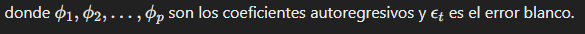

2. **Componente de Diferenciación (I)**:

$$
I(d): \Delta^d y_t = (1 - B)^d y_t
$$

donde \( B \) es el operador de retraso y \( d \) es el orden de la diferenciación.

3. **Componente de Media Móvil (MA)**:

$$
MA(q): y_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \ldots + \theta_q \epsilon_{t-q}
$$

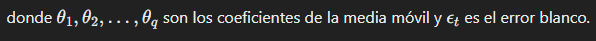

### Modelo ARIMA Combinado
El modelo ARIMA combina estos tres componentes:

$$
ARIMA(p, d, q): \Delta^d y_t = \phi_1 \Delta^d y_{t-1} + \phi_2 \Delta^d y_{t-2} + \ldots + \phi_p \Delta^d y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \ldots + \theta_q \epsilon_{t-q}
$$

donde:
- \( p \) es el orden de la parte autorregresiva (AR).
- \( d \) es el grado de diferenciación.
- \( q \) es el orden de la media móvil (MA).

## CRISP-DM Step 5: Evaluation (Evaluación)
### Evaluar el rendimiento de los modelos y preparar los datos para la presentación final

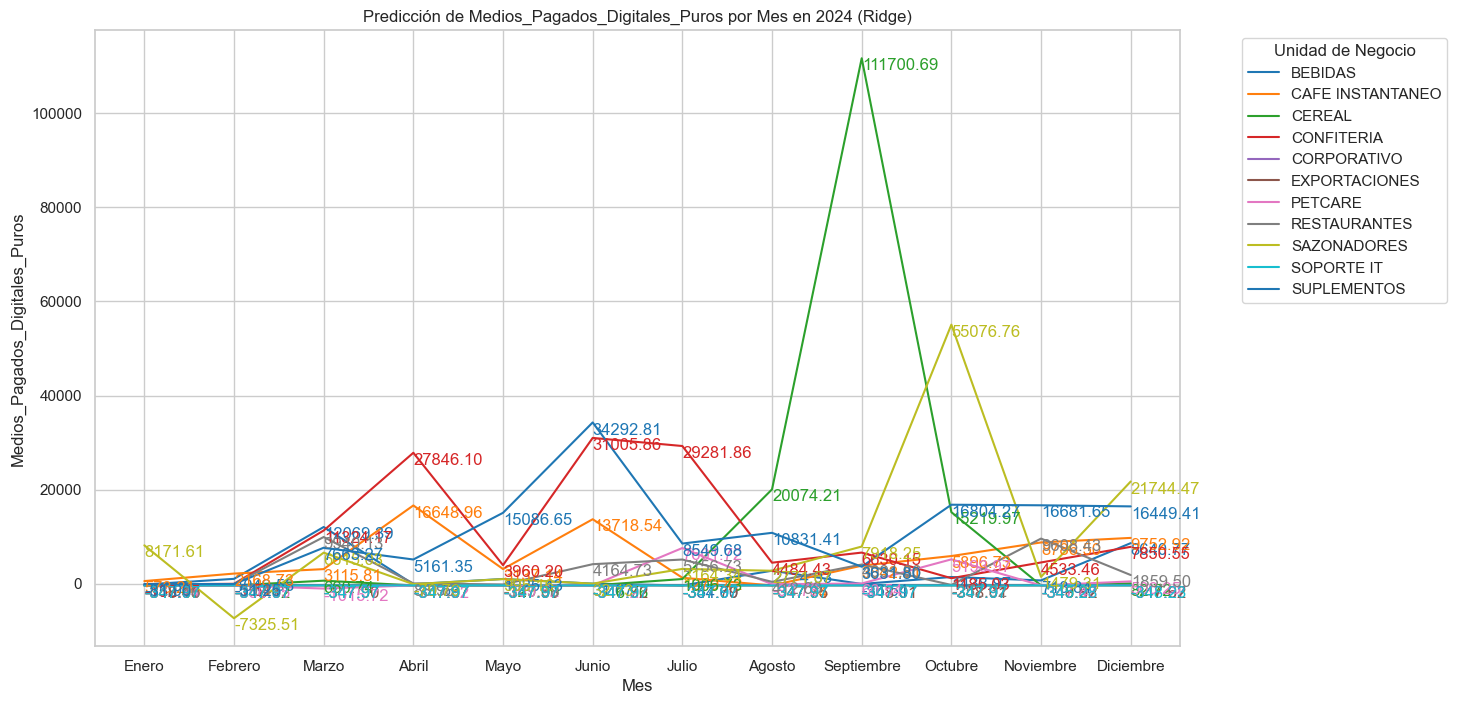

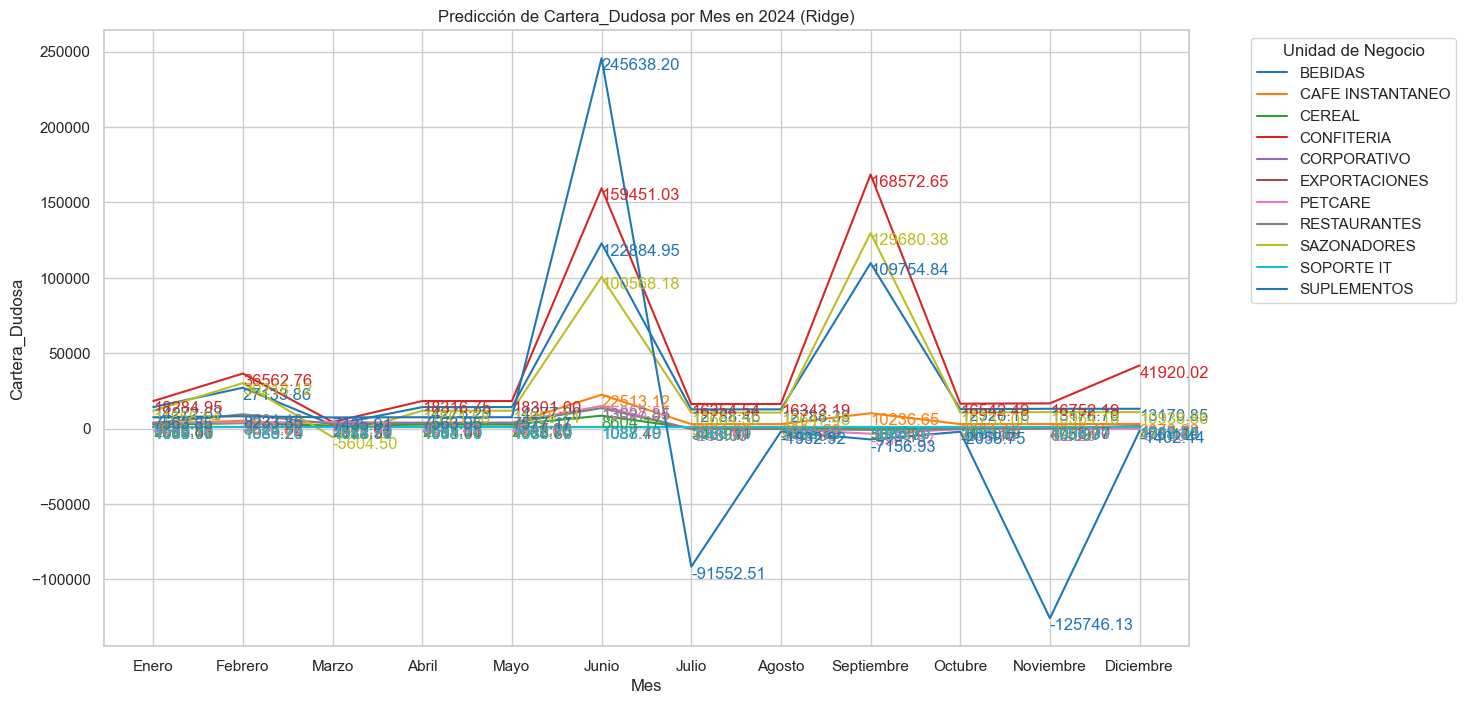

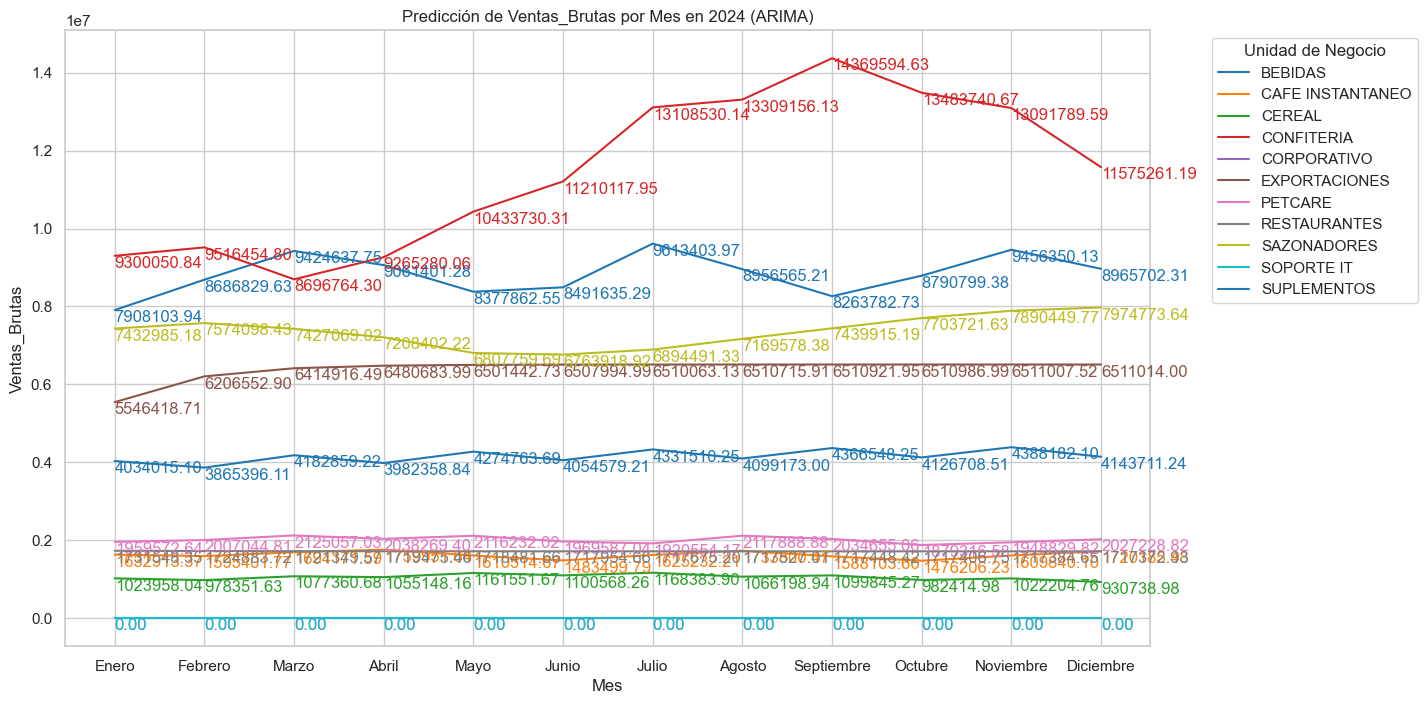

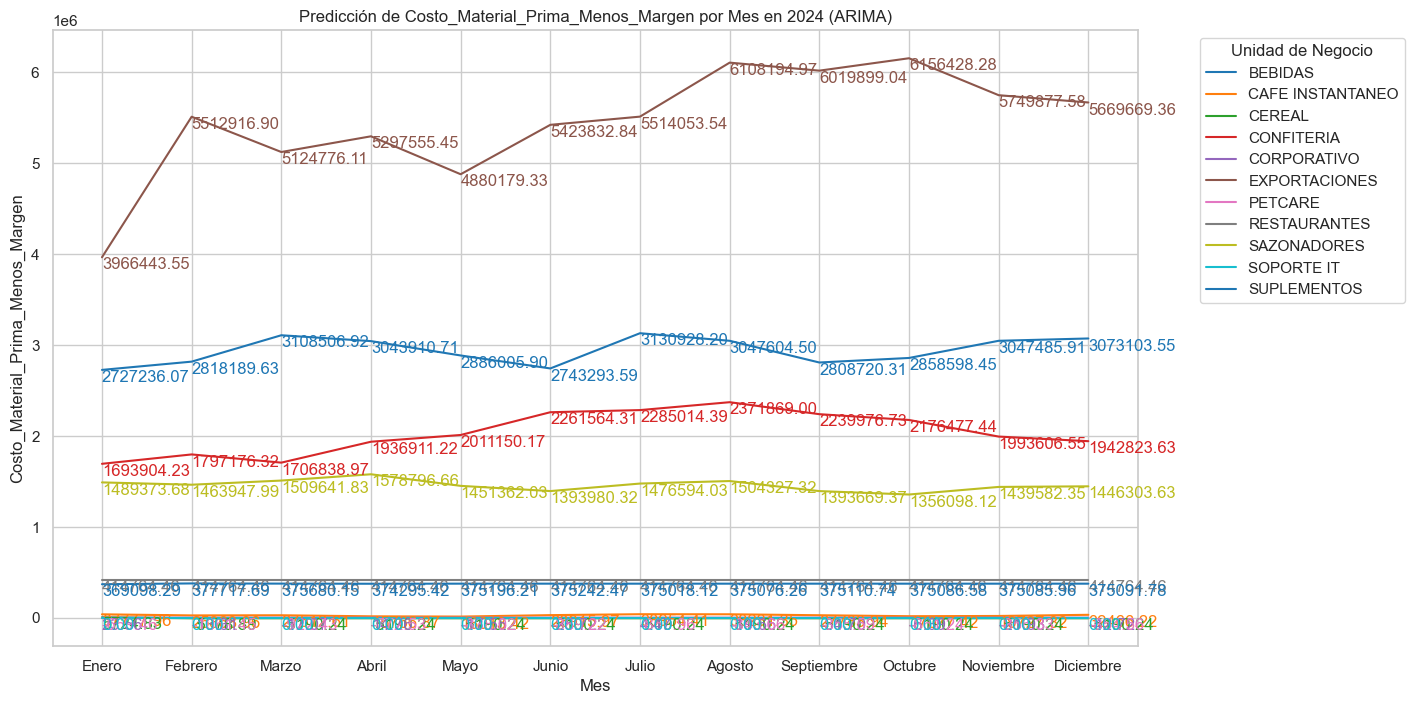

In [66]:
# Variables de interés para las predicciones
variables_ridge = [
    'Medios_Pagados_Digitales_Puros',
    'Cartera_Dudosa'
]

variables_arima = [
    'Ventas_Brutas',
    'Costo_Material_Prima_Menos_Margen'
]

# Nombres de los meses en español
meses_espanol = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

# Función para graficar predicciones
def graficar_predicciones(df, variables, modelo):
    for variable in variables:
        plt.figure(figsize=(14, 8))
        ax = sns.lineplot(data=df, x='Periodo_Publicacion', y=variable, hue='Unidad_Negocio', palette='tab10')
        plt.title(f'Predicción de {variable} por Mes en 2024 ({modelo})')
        plt.xlabel('Mes')
        plt.ylabel(variable)
        plt.xticks(ticks=list(meses_espanol.keys()), labels=list(meses_espanol.values()))
        plt.grid(True)        
        plt.legend(title='Unidad de Negocio', bbox_to_anchor=(1.05, 1), loc='upper left')
        for line in ax.lines:
            for x, y in zip(line.get_xdata(), line.get_ydata()):
                if not pd.isnull(y):
                    ax.text(x, y, f'{y:.2f}', color=line.get_color(), ha="left", va="top")

        plt.show()

# Graficar predicciones de Ridge
graficar_predicciones(predicciones_ridge_2024, variables_ridge, 'Ridge')

# Graficar predicciones de ARIMA
graficar_predicciones(predicciones_arima_2024, variables_arima, 'ARIMA')

In [67]:
# Preparar los datos
datos_agg_ridge = datos_agrupados[["Unidad_Negocio", "Año_Fiscal", "Periodo_Publicacion", "Semestre", "Trimestre", "Codigo_Empresa", "Medios_Pagados_Digitales_Puros", "Cartera_Dudosa"]].copy()
datos_agg_ridge['Fecha'] = pd.to_datetime(datos_agg_ridge.apply(lambda row: f"01/{row['Periodo_Publicacion']:02}/{row['Año_Fiscal']}", axis=1), format='%d/%m/%Y')
datos_pred_ridge = predicciones_ridge_2024.copy()

datos_agg_arima = datos_agrupados[["Unidad_Negocio", "Año_Fiscal", "Periodo_Publicacion", "Semestre", "Trimestre", "Codigo_Empresa", "Ventas_Brutas", "Costo_Material_Prima_Menos_Margen"]].copy()
datos_agg_arima['Fecha'] = pd.to_datetime(datos_agg_arima.apply(lambda row: f"01/{row['Periodo_Publicacion']:02}/{row['Año_Fiscal']}", axis=1), format='%d/%m/%Y')
datos_pred_arima = predicciones_arima_2024.copy()

# Asegurar que las columnas Año_Fiscal tengan el mismo tipo
datos_agg_ridge['Año_Fiscal'] = datos_agg_ridge['Año_Fiscal'].astype(int)
datos_pred_ridge['Año_Fiscal'] = datos_pred_ridge['Año_Fiscal'].astype(int)

datos_agg_arima['Año_Fiscal'] = datos_agg_arima['Año_Fiscal'].astype(int)
datos_pred_arima['Año_Fiscal'] = datos_pred_arima['Año_Fiscal'].astype(int)

# Verificar valores únicos de Año_Fiscal
print("Valores únicos de Año_Fiscal en datos_agg_ridge:")
print(datos_agg_ridge['Año_Fiscal'].unique())

print("Valores únicos de Año_Fiscal en datos_pred_ridge:")
print(datos_pred_ridge['Año_Fiscal'].unique())

print("Valores únicos de Año_Fiscal en datos_agg_arima:")
print(datos_agg_arima['Año_Fiscal'].unique())

print("Valores únicos de Año_Fiscal en datos_pred_arima:")
print(datos_pred_arima['Año_Fiscal'].unique())


Valores únicos de Año_Fiscal en datos_agg_ridge:
[2020 2021 2022 2023]
Valores únicos de Año_Fiscal en datos_pred_ridge:
[2024]
Valores únicos de Año_Fiscal en datos_agg_arima:
[2020 2021 2022 2023]
Valores únicos de Año_Fiscal en datos_pred_arima:
[2024]


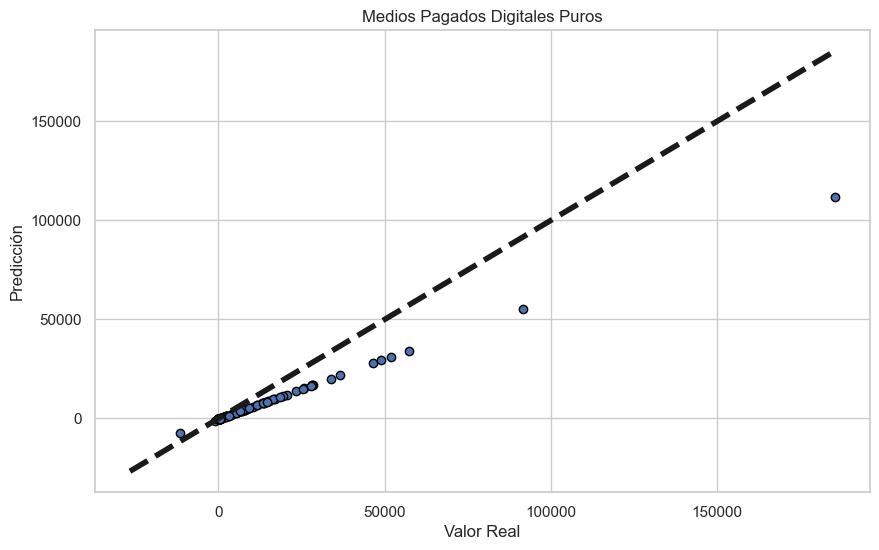

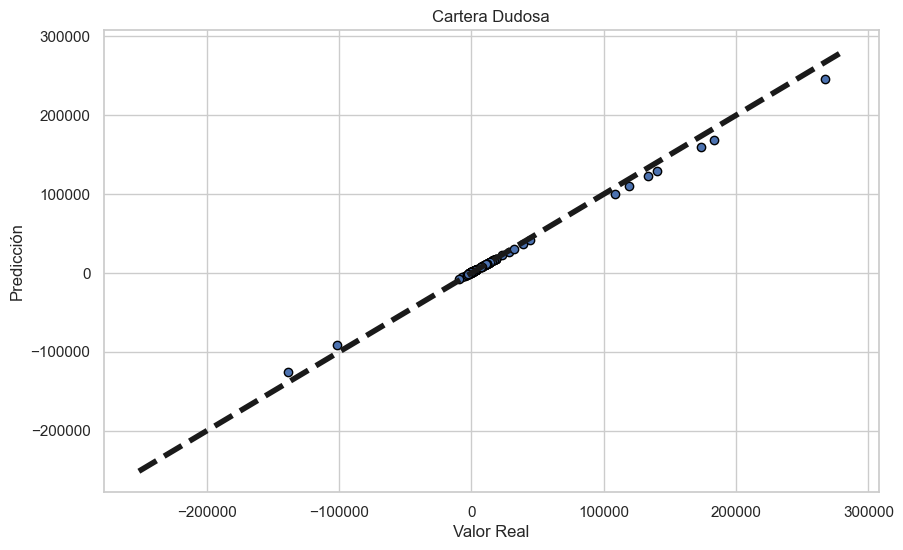

In [68]:
# Comparar las predicciones con los valores reales
targets = ['Ventas_Brutas', 'Medios_Pagados_Digitales_Puros', 'Cartera_Dudosa', 'Costo_Material_Prima_Menos_Margen']

# X_test y y_test se generan a partir de datos_agg_ridge y datos_agg_arima, según el contexto
X_test_ridge = datos_agg_ridge.drop(columns=['Medios_Pagados_Digitales_Puros', 'Cartera_Dudosa'])
y_test_ridge = datos_agg_ridge[['Medios_Pagados_Digitales_Puros', 'Cartera_Dudosa']]

comparison_ridge = X_test_ridge.copy()
comparison_ridge[targets[1]] = y_test_ridge['Medios_Pagados_Digitales_Puros']
comparison_ridge[targets[2]] = y_test_ridge['Cartera_Dudosa']
comparison_ridge['Pred_' + targets[1]] = datos_pred_ridge['Medios_Pagados_Digitales_Puros']
comparison_ridge['Pred_' + targets[2]] = datos_pred_ridge['Cartera_Dudosa']

# Visualización de resultados
def plot_comparison(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.title(title)
    plt.show()

plot_comparison(comparison_ridge[targets[1]], comparison_ridge['Pred_' + targets[1]], 'Medios Pagados Digitales Puros')
plot_comparison(comparison_ridge[targets[2]], comparison_ridge['Pred_' + targets[2]], 'Cartera Dudosa')

## CRISP-DM Step 6: Deployment (Despliegue)
   Combinar datos históricos con predicciones

In [69]:
datos_historicos = datos_agrupados.copy()
datos_completos_ridge = pd.concat([datos_historicos, predicciones_ridge_2024], ignore_index=True)
datos_completos_arima = pd.concat([datos_historicos, predicciones_arima_df], ignore_index=True)
datos_completos_ridge = datos_completos_ridge[["Unidad_Negocio","Año_Fiscal","Periodo_Publicacion","Codigo_Empresa","Medios_Pagados_Digitales_Puros","Cartera_Dudosa"]]
datos_completos_arima = datos_completos_arima[["Unidad_Negocio","Año_Fiscal","Periodo_Publicacion","Codigo_Empresa","Ventas_Brutas","Costo_Material_Prima_Menos_Margen"]]

# Cambiando a cadena 'Año_Fiscal' para poder graficar
datos_completos_ridge['Año_Fiscal'] = datos_completos_ridge['Año_Fiscal'].astype(str)
datos_completos_arima['Año_Fiscal'] = datos_completos_arima['Año_Fiscal'].astype(str)

# Agregar columna Fecha para Dashboard Historico
datos_completos_ridge['Fecha'] = pd.to_datetime(datos_completos_ridge.apply(lambda row: f"01/{row['Periodo_Publicacion']:02}/{row['Año_Fiscal']}", axis=1), format='%d/%m/%Y')
datos_completos_arima['Fecha'] = pd.to_datetime(datos_completos_arima.apply(lambda row: f"01/{row['Periodo_Publicacion']:02}/{row['Año_Fiscal']}", axis=1), format='%d/%m/%Y')

# Agregar columna Fecha para Dashboard Predicción
predicciones_ridge_2024['Fecha'] = pd.to_datetime(predicciones_ridge_2024.apply(lambda row: f"01/{row['Periodo_Publicacion']:02}/{row['Año_Fiscal']}", axis=1), format='%d/%m/%Y')
predicciones_arima_2024['Fecha'] = pd.to_datetime(predicciones_arima_2024.apply(lambda row: f"01/{row['Periodo_Publicacion']:02}/{row['Año_Fiscal']}", axis=1), format='%d/%m/%Y')

# Exportar los resultados de Ridge y ARIMA a un archivo Excel
with pd.ExcelWriter('Predicciones_2024.xlsx', engine='openpyxl') as escritor:
    datos_completos_ridge.to_excel(escritor, sheet_name='Datos_Completos_Ridge', index=False)
    datos_completos_arima.to_excel(escritor, sheet_name='Datos_Completos_ARIMA', index=False)
    predicciones_ridge_2024.to_excel(escritor, sheet_name='Predicciones_Ridge', index=False)
    predicciones_arima_2024.to_excel(escritor, sheet_name='Predicciones_ARIMA', index=False)  
    # Incluir las métricas de Ridge
    metricas_ridge_df = pd.DataFrame(resultados_ridge).T.reset_index()
    metricas_ridge_df.rename(columns={'index': 'Variable'})    
    metricas_ridge_df.to_excel(escritor, sheet_name='Metricas_Ridge', index=False)
    # Incluir las métricas de ARIMA
    metricas_arima_df.to_excel(escritor, sheet_name='Metricas_ARIMA', index=False)

/var/folders/n1/ghplj52d0t3_837cftpxvmx80000gn/T/ipykernel_1691/2053276614.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicciones_ridge_2024['Fecha'] = pd.to_datetime(predicciones_ridge_2024.apply(lambda row: f"01/{row['Periodo_Publicacion']:02}/{row['Año_Fiscal']}", axis=1), format='%d/%m/%Y')


In [70]:
# # Función para insertar datos en la base de datos para manejo en SQL (SOLO AMBIENTE LOCAL CON BASE DE DATOS)
# def insertar_datos(df, tabla, engine):
#     df.to_sql(tabla, con=engine, if_exists='replace', index=False)
#     print(f"Datos insertados en la tabla {tabla}")

# Crear las tablas e insertar los datos
# insertar_datos(datos_completos_ridge, 'NTL_PREDICCIONES_RIDGE_HIS', engine)
# insertar_datos(datos_completos_arima, 'NTL_PREDICCIONES_ARIMA_HIS', engine)

# Opcional insertar solamente predicciones y las métricas 
# insertar_datos(predicciones_ridge_2024, 'NTL_PREDICCIONES_RIDGE', engine)
# insertar_datos(predicciones_arima_2024, 'NTL_PREDICCIONES_ARIMA', engine)
# insertar_datos(metricas_ridge_df, 'METRICAS_RIDGE', engine)
# insertar_datos(metricas_arima_df, 'METRICAS_ARIMA', engine)

# print("Datos exportados a la base de datos MSSQL exitosamente")


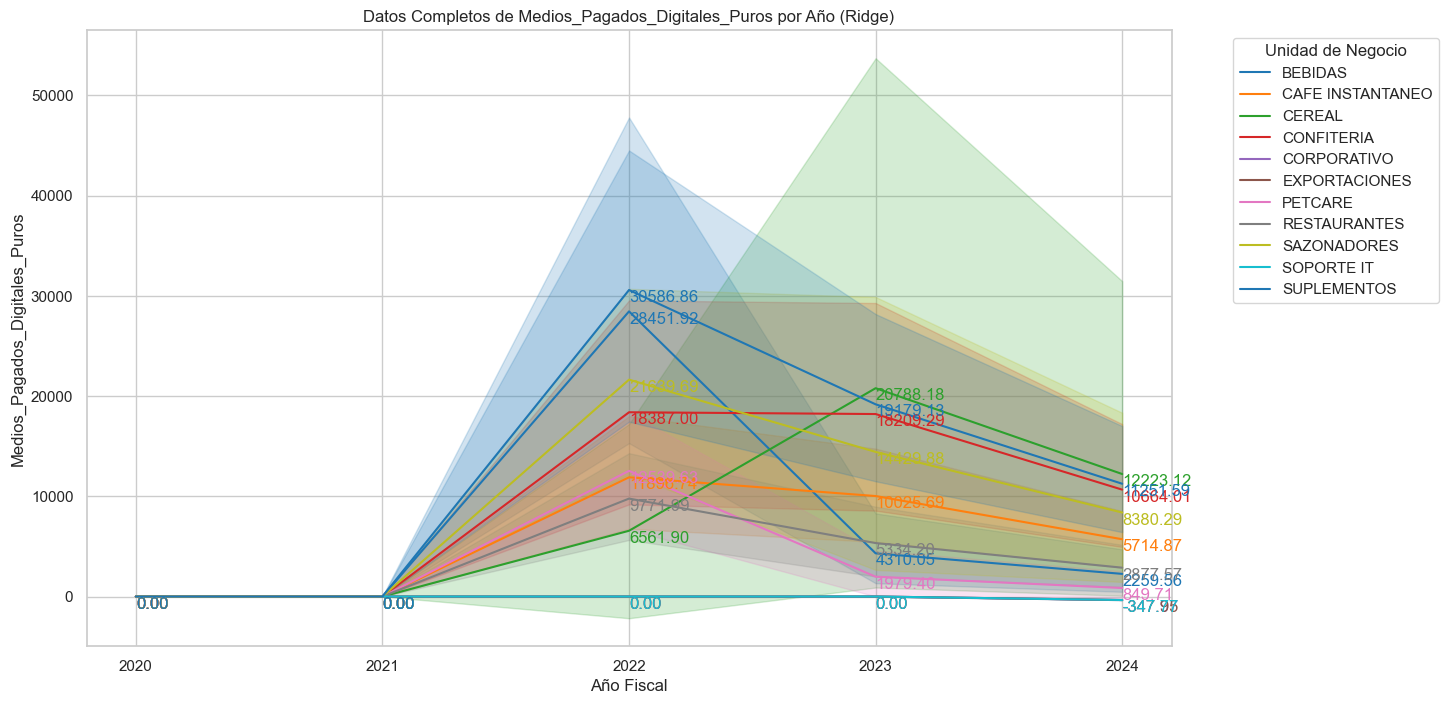

In [71]:
# Variables de interés para los datos completos
variables_ridge = [
    'Medios_Pagados_Digitales_Puros',
    'Cartera_Dudosa'
]

variables_arima = [
    'Ventas_Brutas',
    'Costo_Material_Prima_Menos_Margen'
]

# Función para graficar datos completos
def graficar_datos_completos_por_ano(df, variables, modelo):
    for variable in variables:
        plt.figure(figsize=(14, 8))
        ax = sns.lineplot(data=df, x='Año_Fiscal', y=variable, hue='Unidad_Negocio', palette='tab10')
        plt.title(f'Datos Completos de {variable} por Año ({modelo})')
        plt.xlabel('Año Fiscal')
        plt.ylabel(variable)
        plt.grid(True)
        plt.legend(title='Unidad de Negocio', bbox_to_anchor=(1.05, 1), loc='upper left')
        for line in ax.lines:
            for x, y in zip(line.get_xdata(), line.get_ydata()):
                if not pd.isnull(y):
                    ax.text(x, y, f'{y:.2f}', color=line.get_color(), ha="left", va="top")

        plt.show()

# Graficar datos completos de Ridge
graficar_datos_completos_por_ano(datos_completos_ridge, variables_ridge, 'Ridge')

# Graficar datos completos de ARIMA
graficar_datos_completos_por_ano(datos_completos_arima, variables_arima, 'ARIMA')